#### Some of the necessary imports

In [1]:
from metabolinks import read_aligned_spectra, read_spectra_from_xcel, AlignedSpectra
from metabolinks.similarity import mz_similarity
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns
import pandas as pd
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats
import scaling as sca
import multianalysis as ma
%matplotlib inline

#### Read (reload) aligned from CSV - Building the datasets

### All Positive Mode

Two files:

Norm - '5yeasts_norm_11_12.csv' - Dataset already normalized by the reference feature Leucine Enkephalin in MetaboScape (equal to the normalization function in scaling.py but having all leucine peaks at a certain intensity instead of 1 as it happens in the scaling.py module). m/z delta = 1

None - '5yeasts_notnorm_2.csv' - Dataset without any kind of normalization made by MetaboScape. m/z delta = 1,1

Binary analysis for each one should be identical but as they have a slightly different alignment (m/z delta parameter), they will be slightly different.

#### "None" dataset is more relevant than Norm.

In [2]:
#Transforming MetaboScape .csv files in usable datasets
def reading_MetScape_files(filename, ref_feat = False, h = 1):
    """Reading and Transforming MetaboScape files into datasets.
    
       filename: str; name of the .csv file.
       ref_feat: bool/scalar (default: False); remove reference feature with m/z = ref_feat.
       h: int (default: 1); column to be made index of the dataset (name of rows).
       
       Returns: AlignedSpectra object (from metabolinks) that contains the dataset
    """
    file = pd.read_table(filename, header=[0], sep=',')
    file = file[file[file.columns[h]].notnull()] #Remove features without values in the columns chosen to be the feature names.
    file = file.set_index(file.columns[h]) #Set the column chosen as index/feature name 
    file.index.name = file.columns[h]
    file = file[['BY0_000001', 'BY0_000002', 'BY0_000003',
       'GRE3_000001', 'GRE3_000002', 'GRE3_000003', 'ENO1_000001',
       'ENO1_000002', 'ENO1_000003', 'dGLO1_000001', 'dGLO1_000002',
       'dGLO1_000003', 'GLO2_000001', 'GLO2_000002', 'GLO2_000003']]
    if ref_feat != False:
        file = file.drop([ref_feat])
    MetScape_file = AlignedSpectra(file, labels=["BY","BY","BY","GRE3","GRE3","GRE3","ENO1","ENO1","ENO1","dGLO1","dGLO1",
                                               "dGLO1","GLO2","GLO2","GLO2"])
    return MetScape_file

#### Norm - Already Normalized Dataset from MetaboScape

In [3]:
#Reading from file with MetaboScape Normalization on Leucine Enkephalin.
#Already normalized in MetaboScape - take out reference feature Leucine Enkephalin. 
yeast_norm = reading_MetScape_files('5yeasts_norm_11_12.csv', ref_feat = 556.27657)
yeast_norm.data

,BY0_000001,BY0_000002,BY0_000003,GRE3_000001,GRE3_000002,GRE3_000003,ENO1_000001,ENO1_000002,ENO1_000003,dGLO1_000001,dGLO1_000002,dGLO1_000003,GLO2_000001,GLO2_000002,GLO2_000003
Name,,,,,,,,,,,,,,,
308.09110,1.482951e+09,1.520914e+09,1.515563e+09,1.231184e+09,1.205245e+09,1.227117e+09,7.151679e+08,7.148845e+08,7.031374e+08,5.903519e+08,5.864704e+08,5.959080e+08,287722656.0,2.914869e+08,2.920921e+08
625.09457,4.933358e+08,4.858229e+08,4.977819e+08,5.939113e+08,5.818669e+08,5.844022e+08,3.827252e+08,3.834892e+08,3.807282e+08,2.709398e+08,2.645076e+08,2.677631e+08,131498984.0,1.330865e+08,1.320918e+08
494.32410,4.026932e+08,4.174214e+08,4.232130e+08,4.742500e+08,4.770647e+08,4.894069e+08,8.762351e+07,8.903744e+07,8.863885e+07,8.300221e+07,8.356744e+07,8.238210e+07,56428384.0,5.809368e+07,5.933968e+07
258.11016,2.056732e+08,2.052868e+08,2.117945e+08,2.113430e+08,1.993518e+08,2.069864e+08,2.030151e+08,1.999564e+08,1.930296e+08,1.212009e+08,1.165595e+08,1.169341e+08,59549848.0,6.113070e+07,6.227151e+07
781.11647,1.284203e+08,1.246610e+08,1.314768e+08,1.509135e+08,1.538552e+08,1.479185e+08,9.888932e+07,1.000064e+08,9.630288e+07,6.675784e+07,6.744662e+07,7.063488e+07,33618800.0,3.281881e+07,3.356464e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030.12614,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.487363e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
533.81966,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.487326e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
1071.00423,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.487324e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00


In [4]:
#Replacing 0 values with missing number values for better missing value imputation and feature removal
yeast_nan = yeast_norm.data.replace({0:np.nan})
yeast_norm_nan = AlignedSpectra(yeast_nan, labels=yeast_norm.labels)

In [5]:
#Function to remove features that appear in less the minsample % of the samples
def remove_feat(Spectra, minsample=0):
    """Remove features that appear in less that minsample% of samples.
    
       Spectra: AlignedSpectra object (from metabolinks).
       minsample: scalar (default: 0); minimum percentage of samples a feature must be to not be removed.
       
       Returns: Filtered Aligned Spectra object (from metabolinks).
    """
    Imputated = Spectra
    df = Imputated.data
    if minsample != 0:
        NumValues = Imputated.data.notnull()
        a = 0
        for i in range(0, len(NumValues)):
            if sum(NumValues.iloc[i, :]) < minsample*Imputated.sample_count:
                # Taking away features that appear in less of minsample% of samples.
                df = df.drop([df.iloc[a].name])
            else:
                a = a + 1

    Imputated = AlignedSpectra(
        df, sample_names=Imputated.sample_names, labels=Imputated.labels)
    return Imputated

In [6]:
#Removing features - Lots of features that appear in only 1 sample - non-informative.
yeast_norm_nan = remove_feat(yeast_norm_nan, 2/15) #Features have to appear in at least 2 of the 15 samples
yeast_norm_nan.data

,BY0_000001,BY0_000002,BY0_000003,GRE3_000001,GRE3_000002,GRE3_000003,ENO1_000001,ENO1_000002,ENO1_000003,dGLO1_000001,dGLO1_000002,dGLO1_000003,GLO2_000001,GLO2_000002,GLO2_000003
Name,,,,,,,,,,,,,,,
308.09110,1.482951e+09,1.520914e+09,1.515563e+09,1.231184e+09,1.205245e+09,1.227117e+09,7.151679e+08,7.148845e+08,7.031374e+08,5.903519e+08,5.864704e+08,5.959080e+08,2.877227e+08,2.914869e+08,2.920921e+08
625.09457,4.933358e+08,4.858229e+08,4.977819e+08,5.939113e+08,5.818669e+08,5.844022e+08,3.827252e+08,3.834892e+08,3.807282e+08,2.709398e+08,2.645076e+08,2.677631e+08,1.314990e+08,1.330865e+08,1.320918e+08
494.32410,4.026932e+08,4.174214e+08,4.232130e+08,4.742500e+08,4.770647e+08,4.894069e+08,8.762351e+07,8.903744e+07,8.863885e+07,8.300221e+07,8.356744e+07,8.238210e+07,5.642838e+07,5.809368e+07,5.933968e+07
258.11016,2.056732e+08,2.052868e+08,2.117945e+08,2.113430e+08,1.993518e+08,2.069864e+08,2.030151e+08,1.999564e+08,1.930296e+08,1.212009e+08,1.165595e+08,1.169341e+08,5.954985e+07,6.113070e+07,6.227151e+07
781.11647,1.284203e+08,1.246610e+08,1.314768e+08,1.509135e+08,1.538552e+08,1.479185e+08,9.888932e+07,1.000064e+08,9.630288e+07,6.675784e+07,6.744662e+07,7.063488e+07,3.361880e+07,3.281881e+07,3.356464e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893.53861,NaN,NaN,NaN,2.491379e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.553795e+05,NaN
848.01016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.562285e+06,NaN,NaN,NaN,1.101325e+06,NaN,NaN,NaN
536.64240,NaN,NaN,NaN,NaN,NaN,NaN,1.544839e+06,NaN,NaN,NaN,NaN,NaN,5.424146e+05,NaN,NaN


#### None - Not previously normalized by MetaboScape

In [7]:
#Reading from file without MetaboScape Normalization.
yeast_none = reading_MetScape_files('5yeasts_notnorm_2.csv', ref_feat = False) #Don't take ref_feat, needed for Normalization
yeast_none.data

,BY0_000001,BY0_000002,BY0_000003,GRE3_000001,GRE3_000002,GRE3_000003,ENO1_000001,ENO1_000002,ENO1_000003,dGLO1_000001,dGLO1_000002,dGLO1_000003,GLO2_000001,GLO2_000002,GLO2_000003
Name,,,,,,,,,,,,,,,
308.09110,391042880.0,398003680.0,399481952.0,270906400.0,271023520.0,274854272.0,2.552767e+08,251610656.0,251024624.0,283822048.0,285664416.0,295673952.0,287722656.0,287749600.0,290416512.0
556.27657,111270160.0,110423984.0,111225424.0,92849040.0,94888320.0,94514272.0,1.506205e+08,148516304.0,150645840.0,202869216.0,205537504.0,209370176.0,421969440.0,416559200.0,419548864.0
625.09457,130088936.0,127133608.0,131208568.0,130682664.0,130844488.0,130896568.0,1.366125e+08,134972800.0,135922432.0,130259064.0,128839264.0,132857032.0,131498984.0,131380096.0,131334040.0
494.32410,106187168.0,109233816.0,111553216.0,104352720.0,107277600.0,109619152.0,3.127691e+07,31337604.0,31644646.0,39904768.0,40704944.0,40875840.0,56428384.0,57348836.0,58999288.0
258.11016,54234476.0,53720908.0,55826148.0,46503348.0,44828256.0,46361588.0,7.246554e+07,70376640.0,68912816.0,58269456.0,56775068.0,58019620.0,59549848.0,60346920.0,61914296.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030.12614,0.0,0.0,0.0,0.0,0.0,0.0,5.309092e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
533.81966,0.0,0.0,0.0,0.0,0.0,0.0,5.308958e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1071.00423,0.0,0.0,0.0,0.0,0.0,0.0,5.308951e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#Replacing 0 values with missing number values for better missing value imputation and feature removal
yeast_none_nan2 = yeast_none.data.replace({0:np.nan})
yeast_none_nan = AlignedSpectra(yeast_none_nan2, labels=yeast_none.labels)

In [9]:
#Removing Features - Lots of features that appear in only 1 sample - non-informative.
yeast_none_nan = remove_feat(yeast_none_nan, 2/15) #Features have to appear in at least 2 of the 15 samples.
yeast_none_nan.data

,BY0_000001,BY0_000002,BY0_000003,GRE3_000001,GRE3_000002,GRE3_000003,ENO1_000001,ENO1_000002,ENO1_000003,dGLO1_000001,dGLO1_000002,dGLO1_000003,GLO2_000001,GLO2_000002,GLO2_000003
Name,,,,,,,,,,,,,,,
308.09110,391042880.0,398003680.0,399481952.0,270906400.0,271023520.0,274854272.0,2.552767e+08,2.516107e+08,2.510246e+08,283822048.0,285664416.0,2.956740e+08,2.877227e+08,2.877496e+08,290416512.0
556.27657,111270160.0,110423984.0,111225424.0,92849040.0,94888320.0,94514272.0,1.506205e+08,1.485163e+08,1.506458e+08,202869216.0,205537504.0,2.093702e+08,4.219694e+08,4.165592e+08,419548864.0
625.09457,130088936.0,127133608.0,131208568.0,130682664.0,130844488.0,130896568.0,1.366125e+08,1.349728e+08,1.359224e+08,130259064.0,128839264.0,1.328570e+08,1.314990e+08,1.313801e+08,131334040.0
494.32410,106187168.0,109233816.0,111553216.0,104352720.0,107277600.0,109619152.0,3.127691e+07,3.133760e+07,3.164465e+07,39904768.0,40704944.0,4.087584e+07,5.642838e+07,5.734884e+07,58999288.0
258.11016,54234476.0,53720908.0,55826148.0,46503348.0,44828256.0,46361588.0,7.246554e+07,7.037664e+07,6.891282e+07,58269456.0,56775068.0,5.801962e+07,5.954985e+07,6.034692e+07,61914296.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893.53861,NaN,NaN,NaN,548196.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.482588e+05,NaN
848.01016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.498614e+05,NaN,NaN,NaN,5.464487e+05,NaN,NaN,NaN
536.64240,NaN,NaN,NaN,NaN,NaN,NaN,5.514251e+05,NaN,NaN,NaN,NaN,NaN,5.424146e+05,NaN,NaN


## Similarity analysis

#### Compute m/z similarities

In [10]:
sim_norm = mz_similarity(yeast_norm_nan)
sim_none = mz_similarity(yeast_none_nan)

In [11]:
print(sim_norm)


Sample similarity, counts of common peaks
              BY0_000001  BY0_000002  BY0_000003  GRE3_000001  GRE3_000002  \
BY0_000001           706         510         531          402          423   
BY0_000002           510         747         538          398          413   
BY0_000003           531         538         734          399          426   
GRE3_000001          402         398         399          678          461   
GRE3_000002          423         413         426          461          696   
GRE3_000003          416         427         430          463          509   
ENO1_000001          350         346         353          328          341   
ENO1_000002          390         392         399          347          364   
ENO1_000003          378         380         390          327          353   
dGLO1_000001         421         450         446          374          392   
dGLO1_000002         424         441         448          367          398   
dGLO1_000003         

In [12]:
print(sim_none)


Sample similarity, counts of common peaks
              BY0_000001  BY0_000002  BY0_000003  GRE3_000001  GRE3_000002  \
BY0_000001           719         512         532          405          425   
BY0_000002           512         757         541          400          417   
BY0_000003           532         541         744          403          428   
GRE3_000001          405         400         403          699          464   
GRE3_000002          425         417         428          464          712   
GRE3_000003          419         430         432          465          513   
ENO1_000001          352         349         354          333          344   
ENO1_000002          392         394         400          351          367   
ENO1_000003          379         381         390          329          356   
dGLO1_000001         424         451         446          377          393   
dGLO1_000002         427         442         452          369          400   
dGLO1_000003         

Example of some binary similarity betwee samples with the Norm dataset (almost identical no None dataset)

In [13]:
dfnorm = pd.DataFrame(sim_norm.sample_similarity_jaccard,
                     columns=sim_norm.sample_names,
                     index=sim_norm.sample_names)

Sample similarity, Norm dataset


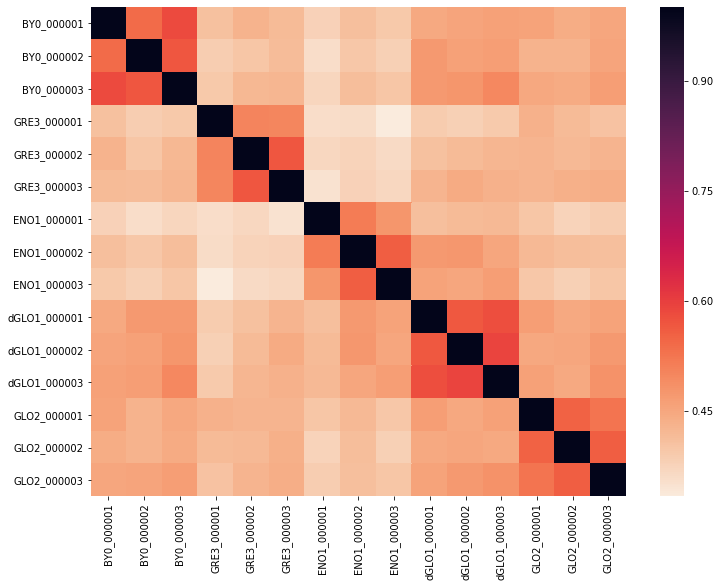

In [14]:
f, ax = plt.subplots(figsize=(12, 9))

print('Sample similarity, Norm dataset')
hm = sns.heatmap(dfnorm, annot=False, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [15]:
dfnorm = pd.DataFrame(sim_norm.label_similarity_jaccard,
                     columns=sim_norm.unique_labels,
                     index=sim_norm.unique_labels)

Label similarity, Norm dataset


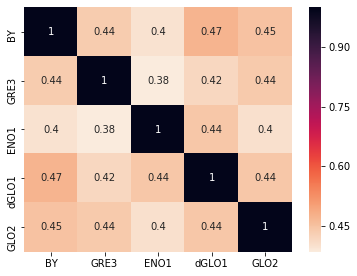

In [16]:
f, ax = plt.subplots(figsize=(6, 4.5))

print('Label similarity, Norm dataset')
hm = sns.heatmap(dfnorm, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### Doing... Experiments with scipy functions...

In [17]:
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    df = df.copy()
    df[df.notnull()] = 1
    df[df.isnull()] = 0
    return df
aligned_01 = df_to_bool(yeast_norm_nan.data)
# confirm it is 0's and 1's
#aligned_01
#yeast_norm.data[yeast_norm.data == 0]

In [18]:
jdist = dist.pdist(aligned_01.T, metric='jaccard')
#print(dist.squareform(jdist))
#print('------------------------------------')
sim = mz_similarity(yeast_norm_nan)
jsim = sim.sample_similarity_jaccard
jdist = 1 - jsim
#print(jdist)

Yeast dendogram, Jaccard distance, Norm dataset


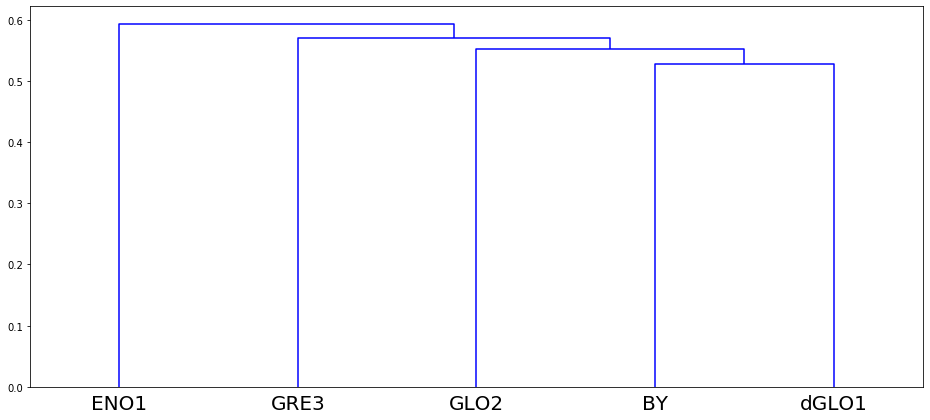

In [19]:
print('Yeast dendogram, Jaccard distance, Norm dataset')
jdist = dist.squareform(1 - sim_norm.label_similarity_jaccard)
Z = hier.linkage(jdist, method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z, labels=sim_norm.unique_labels,
                     leaf_font_size=20,
                     above_threshold_color='b')

In [20]:
print(hier.cophenet(Z,jdist)[0])

0.8141336262504134


### Non-binary Similarity Analysis


Creating the colours label for all dendrograms (norm and none have the same labels):

In [21]:
label_colors = {}
colours = cm.get_cmap('nipy_spectral', 5)
col_lbl = colours(range(5))
for i in range(len(col_lbl)):
    label_colors[yeast_norm_nan.labels[3*i]] = col_lbl[i]

### Normalized MetaboScape Data (m/z delta = 1)

3 types of processing:

Imp_neg - MetScape Normalization, Missing Value Imputation.

P_norm - MetScape Normalization, Missing Value Imputation and Pareto Scaling.

NGP_norm - MetScape Normalization, Missing Value Imputation, glog transformation and Pareto Scaling.

Note: Starts without Leucine Enkephalin peak.

In [22]:
#Imp_norm 
Imp_norm = sca.NaN_Imputation(yeast_norm_nan, 0) #Substitute missing values with half of the minimum intensity.
#Imp_norm.data

In [23]:
Norm_none2 = sca.Norm_Feat(yeast_none_nan, 556.27657)

In [24]:
#Measure Euclidean distances
#dist_Imp_none2 = dist.pdist(Imp_none2.data.T, metric = 'euclidean')

#Constructing Dendrogram
#print('Yeast dendrogram, Euclidean distance, MetScape Normalization and NaN Imputation')
#Z_Imp_none2 = hier.linkage(dist_Imp_none2, method='average') #ward, average, centroid, single, complete, weighted, median
#fig = plt.figure(figsize=(16,7))
#dn = hier.dendrogram(Z_Imp_none2, labels=Imp_none2.labels,
                     #leaf_font_size=15,
                     #above_threshold_color='b')
#Coloring labels
#ax = plt.gca()
#ax.set_ylabel('Distance (UA)')
#xlbls = ax.get_xmajorticklabels()
#for lbl in xlbls:
    #lbl.set_color(label_colors[lbl.get_text()])

Yeast dendrogram, Euclidean distance, MetScape Normalization and NaN Imputation


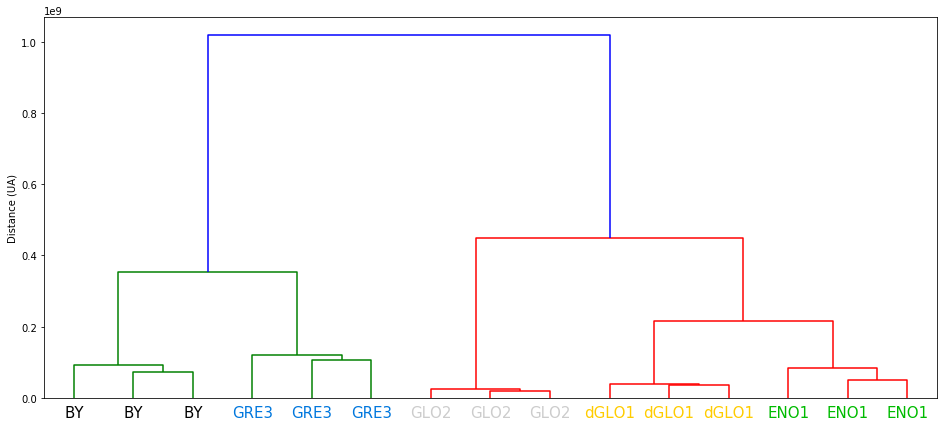

In [25]:
#Measure Euclidean distances
dist_Imp_norm = dist.pdist(Imp_norm.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Yeast dendrogram, Euclidean distance, MetScape Normalization and NaN Imputation')
Z_Imp_norm = hier.linkage(dist_Imp_norm, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_Imp_norm, labels=Imp_norm.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [26]:
#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
print(hier.cophenet(Z_Imp_norm,dist_Imp_norm)[0]) #method average seems to lead to higher coefficients

0.9253713106371382


In [27]:
#P_norm
P_norm = sca.ParetoScal(Imp_norm)

Yeast dendrogram, Euclidean distance, MetScape Normalization, NaN Imputation and Pareto Scaling


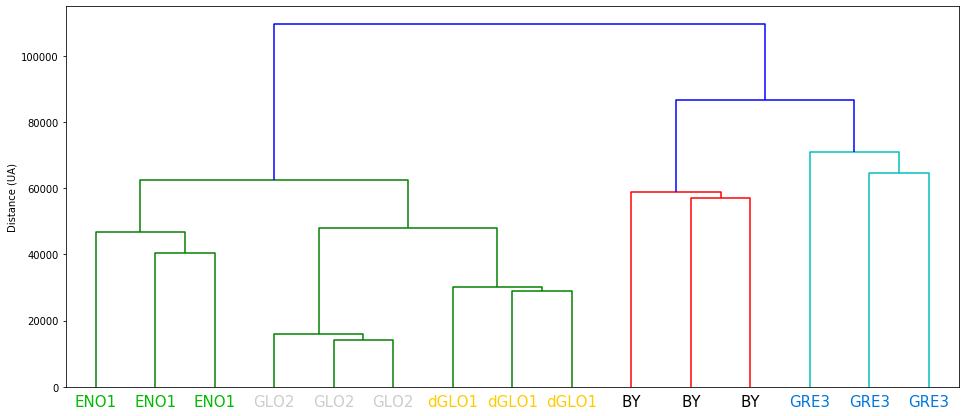

In [28]:
#Measure Euclidean distances
dist_P_norm = dist.pdist(P_norm.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Yeast dendrogram, Euclidean distance, MetScape Normalization, NaN Imputation and Pareto Scaling')
Z_P_norm = hier.linkage(dist_P_norm, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_P_norm, labels=P_norm.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [29]:
#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
print(hier.cophenet(Z_P_norm,dist_P_norm)[0]) #method average seems to lead to higher coefficients

0.9491414827411592


In [30]:
#NGP_norm
glog_norm = sca.glog(Imp_norm, 0)
NGP_norm = sca.ParetoScal(glog_norm)

Yeast dendrogram, Euclidean distance, MetScape Normalization, NaN Imputation, Transformed and Pareto Scaling


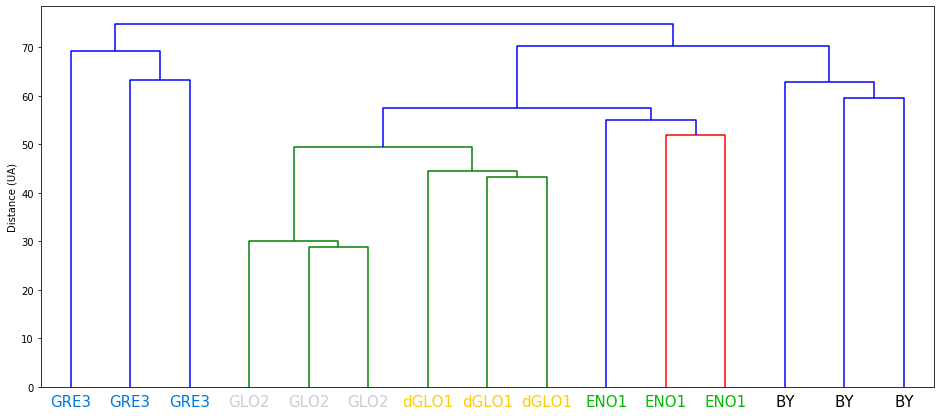

In [31]:
#Measure Euclidean distances
dist_NGP_norm = dist.pdist(NGP_norm.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Yeast dendrogram, Euclidean distance, MetScape Normalization, NaN Imputation, Transformed and Pareto Scaling')
Z_NGP_norm = hier.linkage(dist_NGP_norm, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_NGP_norm, labels=NGP_norm.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [32]:
print(hier.cophenet(Z_NGP_norm,dist_NGP_norm)[0]) 

0.9778042613275114


### Binary Similarity Analysis Methods - Example Dendrogram

In [33]:
aligned_norm = df_to_bool(yeast_norm_nan.data)

Yeast dendrogram, Binary methods, Normalized by MetScape


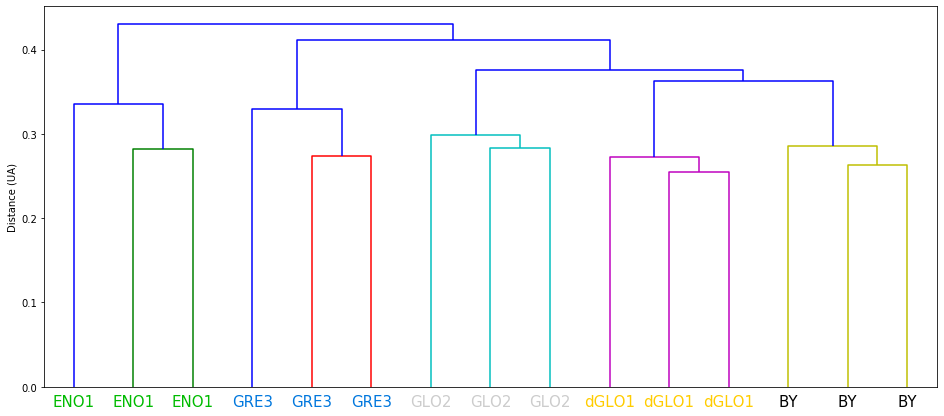

In [34]:
#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice_neg = hier.linkage(aligned_norm.T, metric = 'dice', method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Zdice_neg, labels=yeast_norm_nan.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

### Not-normalized MetaboScape Data

4 types of processing:

Imp_none - Missing Value Imputation

P_none - Missing Value Imputation and Pareto Scaling.

NP_none - Missing Value Imputation, Normalization by a reference feature (Leucine Enkephalin) and Pareto Scaling.

NGP_none - Missing Value Imputation, Normalization by a reference feature (Leucine Enkephalin), glog transformation and Pareto Scaling.

Note: Leucine Enkephalin peak was taken out when Normalization happened.

In [35]:
#Imp_none
Imp_none = sca.NaN_Imputation(yeast_none_nan, 0)

Yeast dendrogram, Euclidean distance, NaN Imputation


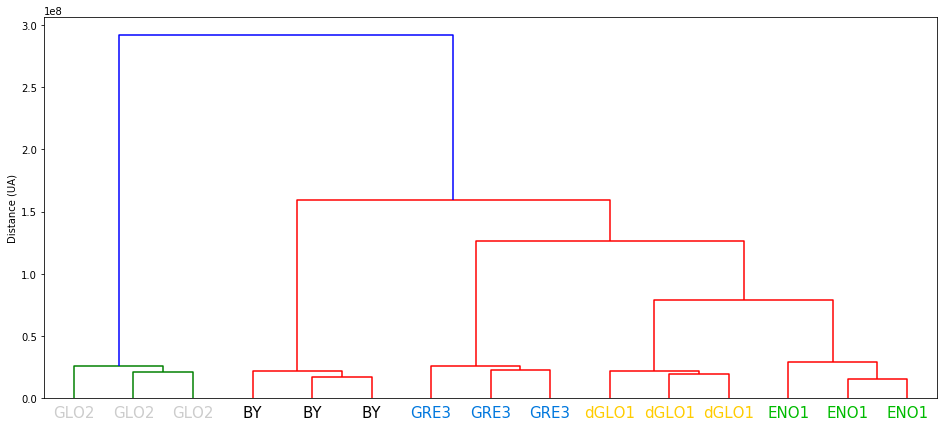

In [36]:
#Measure Euclidean distances
dist_Imp_none = dist.pdist(Imp_none.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Yeast dendrogram, Euclidean distance, NaN Imputation')
Z_Imp_none = hier.linkage(dist_Imp_none, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_Imp_none, labels=Imp_none.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [37]:
#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
print(hier.cophenet(Z_Imp_none,dist_Imp_none)[0]) #method average seems to lead to higher coefficients

0.9545344927395418


In [38]:
#P_none
P_none = sca.ParetoScal(Imp_none)

Yeast dendrogram, Euclidean distance, NaN Imputation and Pareto Scaling


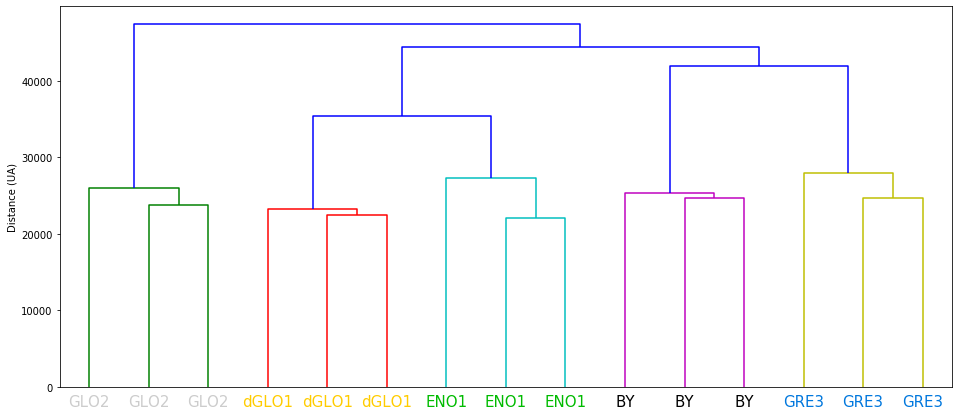

In [39]:
#Measure Euclidean distances
dist_P_none = dist.pdist(P_none.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Yeast dendrogram, Euclidean distance, NaN Imputation and Pareto Scaling')
Z_P_none = hier.linkage(dist_P_none, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_P_none, labels=P_none.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [40]:
#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
print(hier.cophenet(Z_P_none,dist_P_none)[0]) #method average seems to lead to higher coefficients

0.9307935019014197


In [41]:
#NP_none
Norm_none = sca.Norm_Feat(Imp_none, 556.27657)
NP_none = sca.ParetoScal(Norm_none)

Yeast dendrogram, Euclidean distance, NaN Imputation, Normalized and Pareto Scaling


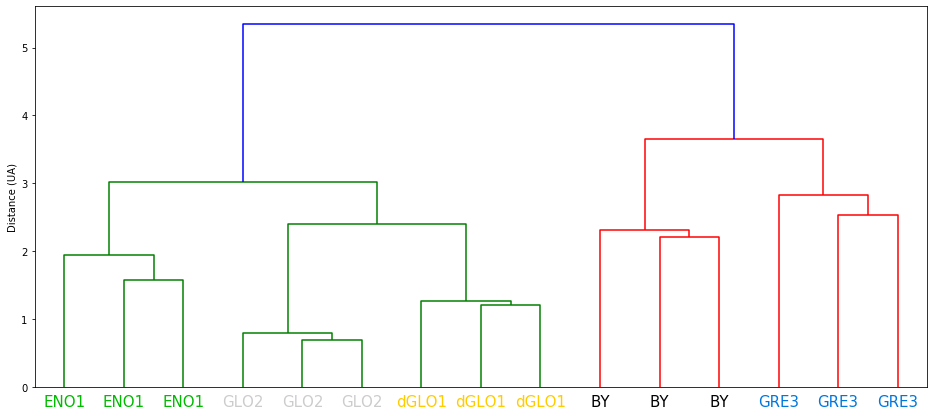

In [42]:
#Measure Euclidean distances
dist_NP_none = dist.pdist(NP_none.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Yeast dendrogram, Euclidean distance, NaN Imputation, Normalized and Pareto Scaling')
Z_NP_none = hier.linkage(dist_NP_none, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_NP_none, labels=NP_none.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [43]:
print(hier.cophenet(Z_NP_none,dist_NP_none)[0]) 

0.918788488797976


In [44]:
#NGP_none
glog_none = sca.glog(Norm_none, 0)
NGP_none = sca.ParetoScal(glog_none)

Yeast dendrogram, Euclidean distance, NaN Imputation, Normalized, Transformed and Pareto Scaling


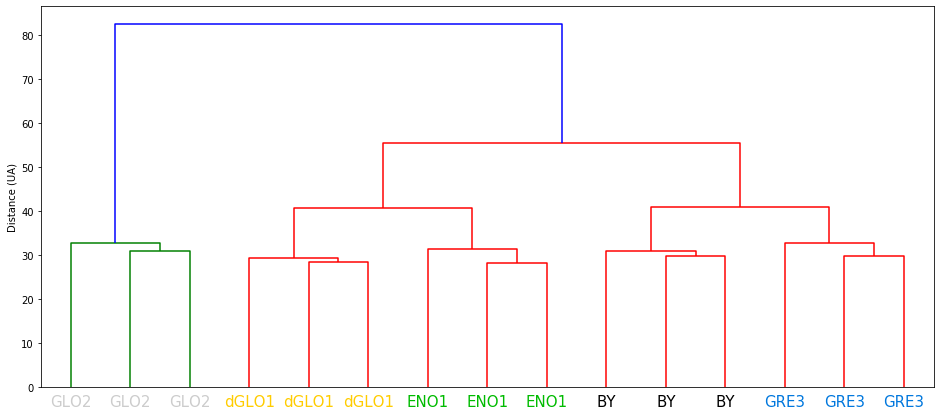

In [45]:
#Measure Euclidean distances
dist_NGP_none = dist.pdist(NGP_none.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Yeast dendrogram, Euclidean distance, NaN Imputation, Normalized, Transformed and Pareto Scaling')
Z_NGP_none = hier.linkage(dist_NGP_none, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_NGP_none, labels=NGP_none.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [46]:
print(hier.cophenet(Z_NGP_none,dist_NGP_none)[0]) 

0.8657469593166434


### Binary Similarity Analysis Methods - Example Dendrogram

In [47]:
aligned_none = df_to_bool(yeast_none_nan.data)

Yeast dendrogram, Binary methods, Not-Normalized by MetScape


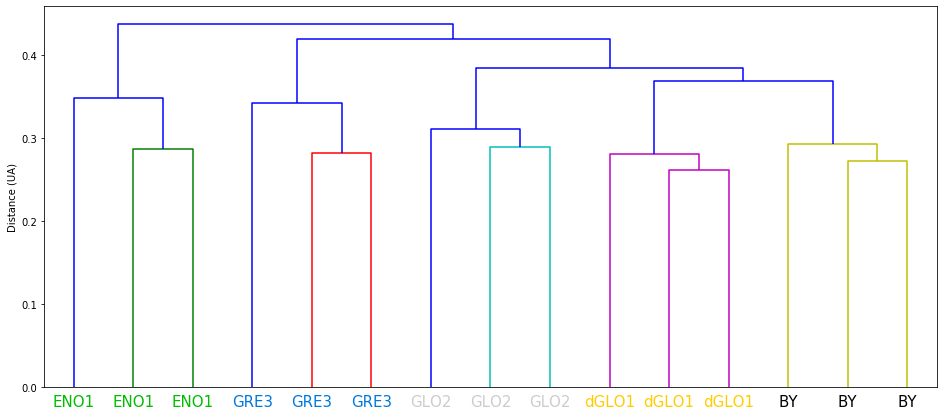

In [48]:
#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

print('Yeast dendrogram, Binary methods, Not-Normalized by MetScape')
Zdice_neg = hier.linkage(aligned_none.T, metric = 'dice', method ='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Zdice_neg, labels=yeast_none_nan.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

### Comparing Dendrograms

#### Two methods: Baker's Gamma Correlation and Cophenetic Correlation Coefficient

#### Examples of procedure with these methods

#### Baker's method

Use of the mergerank function from multianalysis to create a 'rank' of the iteration number two samples were linked to the same cluster.

In [49]:
euclidean = (Z_Imp_norm, Z_P_norm, Z_NGP_norm, Z_Imp_none, Z_P_none, Z_NP_none, Z_NGP_none)
dist_euclidean = (dist_Imp_norm, dist_P_norm, dist_NGP_norm, dist_Imp_none, dist_P_none, dist_NP_none, dist_NGP_none)

#euclidean = (Z_Imp_none, Z_P_none, Z_NP_none, Z_NGP_none)
#dist_euclidean = (dist_Imp_none, dist_P_none, dist_NP_none, dist_NGP_none)

K_BG = []
S_BG = []
Coph_C = []

for i in range(len(euclidean)):
    K_BG.append(ma.mergerank(euclidean[i])) #Mergerank
    S_BG.append(K_BG[i][K_BG[i]!=0]) #Both reshape to a 1D array (needed for spearman correlation) and take out 0's 
    Coph_C.append(hier.cophenet(euclidean[i], dist_euclidean[i])) #Matrix of Cophenetic distances

#### Examples

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [50]:
print('Pair of samples      \tKendall Correlation \tp-value')
print('Imp_norm-P_norm   \t', stats.kendalltau(S_BG[0],S_BG[1])[0], '\t', stats.kendalltau(S_BG[0],S_BG[1])[1])
print('Imp_norm-_NGP_norm\t', stats.kendalltau(S_BG[0],S_BG[2])[0], '\t', stats.kendalltau(S_BG[0],S_BG[2])[1])

Pair of samples      	Kendall Correlation 	p-value
Imp_norm-P_norm   	 0.7920505396156882 	 2.587411368337444e-43
Imp_norm-_NGP_norm	 0.524947529104374 	 1.5116315686103824e-20


According to the explanation given in the R package dendextend

In [51]:
print('Pair of samples      \tSpearman Correlation \tp-value')
print('Imp_norm-P_norm   \t', stats.spearmanr(S_BG[0],S_BG[1])[0], '\t', stats.spearmanr(S_BG[0],S_BG[1])[1])
print('Imp_norm-_NGP_norm\t', stats.spearmanr(S_BG[0],S_BG[2])[0], '\t', stats.spearmanr(S_BG[0],S_BG[2])[1])

Pair of samples      	Spearman Correlation 	p-value
Imp_norm-P_norm   	 0.9093678046304186 	 3.5736583585311486e-81
Imp_norm-_NGP_norm	 0.6377481669796734 	 2.2572148774456796e-25


#### Cophenetic Correlation Coefficient

In [52]:
print('Pair of samples      \tPearson Correlation \tp-value')
print('Imp_norm-P_norm   \t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[1])
print('Imp_norm-_NGP_norm\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[1])

Pair of samples      	Pearson Correlation 	p-value
Imp_norm-P_norm   	 0.9103218453518863 	 2.983812032298868e-41
Imp_norm-_NGP_norm	 0.7132362823214757 	 1.3848761189473696e-17


### Comparison of dendrograms made with all binary metrics and euclidean distances 

#### Correlations between all pairs using all 3 methods

In [53]:
#9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')
#3 methods that will be used as representative of the others (others not present have similar variations to one of those 3)
binary = ( 'jaccard', 'hamming', 'yule')

In [54]:
#Application of all "single" steps needed presented in the examples above with distance metrics.
#Normalized first by Metaboscape
Z_norm = []
K_norm = []
S_norm = []
Coph_norm = []

for i in range(len(binary)):
    Z_norm.append(hier.linkage(aligned_norm.T, metric = binary[i], method='average')) #Z
    K_norm.append(ma.mergerank(Z_norm[i])) #Mergerank
    S_norm.append(K_norm[i][K_norm[i]!=0]) #Eliminating 0's
    Coph_norm.append(hier.cophenet(Z_norm[i], dist.pdist(aligned_norm.T, metric = binary[i]))) #Cophenetic

In [55]:
#Not Normalized first
Z_none = []
K_none = []
S_none = []
Coph_none = []

for i in range(len(binary)):
    Z_none.append(hier.linkage(aligned_none.T, metric = binary[i], method='average')) #Z
    K_none.append(ma.mergerank(Z_none[i])) #Mergerank
    S_none.append(K_none[i][K_none[i]!=0]) #Eliminating 0's
    Coph_none.append(hier.cophenet(Z_none[i], dist.pdist(aligned_none.T, metric = binary[i]))) #Cophenetic

In [56]:
#Creation of a list with all the "rank" values (in order) for the different metrics: 
#Norm Conventional, None Conventional, Norm Binaries, None Binaries
S = []
S.extend(S_BG)
S.extend(S_norm)#
S.extend(S_none)
#Creation of a list with all the returns from the function cophenetic for the different metrics: 
#Norm Conventional, None Conventional, Norm Binaries, None Binaries
Coph = []
Coph.extend(Coph_C)
Coph.extend(Coph_norm)#
Coph.extend(Coph_none)

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [57]:
#Column names and row names for the dataframes
colnames = ['Imp_norm', 'P_norm', 'NGP_norm', 'Imp_none', 'P_none', 'NP_none', 'NGP_none', 'jaccard_norm', 'hamming_norm',
            'yule_norm', 'jaccard_none', 'hamming_none', 'yule_none']
#colnames = ['Imp_none', 'P_none', 'NP_none', 'NGP_none', 'jaccard_none', 'hamming_none', 'yule_none']            
            #'dice_norm', 'hamming_norm',
            #'jaccard_norm', 'rogerstanimoto_norm', 'sokalmichener_norm', 'sokalsneath_norm','yule_norm', 'kulsinski_norm', 
            #'russellrao_norm','dice_none', 'hamming_none', 'jaccard_none', 'rogerstanimoto_none', 
            #'sokalmichener_none', 'sokalsneath_none', 'yule_none', 'kulsinski_none', 'russellrao_none']

In [58]:
df_K = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #K - Kendall (Baker)
df_S = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #S - Spearman (Baker)
df_C = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #C - Cophenetic Correlation
df_K_p = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #p-values of K method
df_S_p = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #p-values of S method
df_C_p = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #p-values of C method

In [59]:
#Calculation of correlation coefficient for each method
for i in range(len(S)):
    for j in range(len(S)):
        df_K.iloc[i,j] = stats.kendalltau(S[i],S[j])[0] #Correlation coefficient
        df_S.iloc[i,j] = stats.spearmanr(S[i],S[j])[0] #Correlation coefficient
        df_C.iloc[i,j] = stats.pearsonr(Coph[i][1],Coph[j][1])[0] #Correlation coefficient
        df_K_p.iloc[i,j] = stats.kendalltau(S[i],S[j])[1] #p-value
        df_S_p.iloc[i,j] = stats.spearmanr(S[i],S[j])[1] #p-value
        df_C_p.iloc[i,j] = stats.pearsonr(Coph[i][1],Coph[j][1])[1] #p-value

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,len(S)))* np.nan, columns = colnames, index=[''])
lineV = pd.concat([line.iloc[:,:7], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,7:]], axis = 1)
df_KI = pd.concat([df_K.iloc[:7], line, df_K.iloc[7:]])
df_KI = pd.concat([df_KI.iloc[:,:7], lineV.T, df_KI.iloc[:,7:]], axis = 1)
df_SI = pd.concat([df_S.iloc[:7], line, df_S.iloc[7:]])
df_SI = pd.concat([df_SI.iloc[:,:7], lineV.T, df_SI.iloc[:,7:]], axis = 1)
df_CI = pd.concat([df_C.iloc[:7], line, df_C.iloc[7:]])
df_CI = pd.concat([df_CI.iloc[:,:7], lineV.T, df_CI.iloc[:,7:]], axis = 1)
#line = pd.DataFrame(np.empty((1,10))* np.nan, columns = ['Imp_none', 'P_none', 'NP_none', 'NGP_none', 'jaccard_norm', 'hamming_norm',
            #'yule_norm', 'jaccard_none', 'hamming_none', 'yule_none'], index=[''])
#lineV = pd.concat([line.iloc[:,:4], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,4:]], axis = 1)
#df_CI = pd.concat([df_C.iloc[3:7, 3:], line, df_C.iloc[10:,3:]])
#df_CI = pd.concat([df_CI.iloc[:,:4], lineV.T, df_CI.iloc[:,4:]], axis = 1)

### Heatmaps of the correlation coeficients for the 3 methods

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: Treatment/Binary metric_data type
Norm - MetaboScape normalized data
None - MetaboScape not normalized data


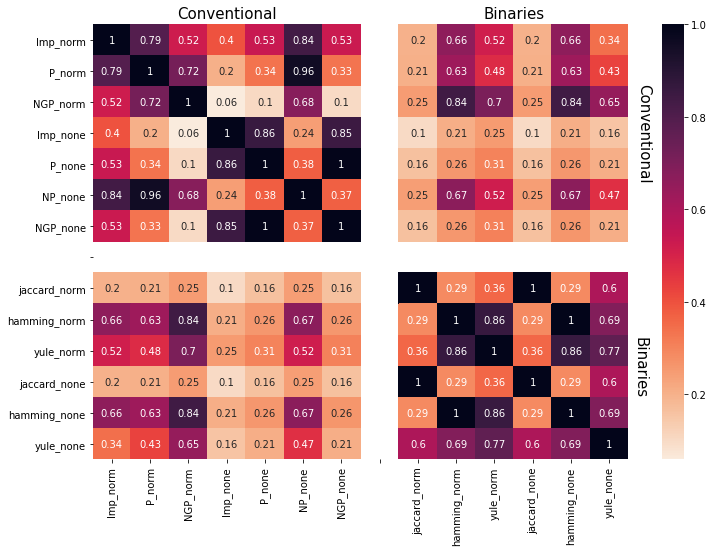

In [60]:
f, ax = plt.subplots(figsize=(12, 8))

print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: Treatment/Binary metric_data type')
print('Norm - MetaboScape normalized data')
print('None - MetaboScape not normalized data')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3.5,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(14.2,3.5,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(11,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(14.1,11,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: Treatment/Binary metric_data type
Norm - MetaboScape normalized data
None - MetaboScape not normalized data


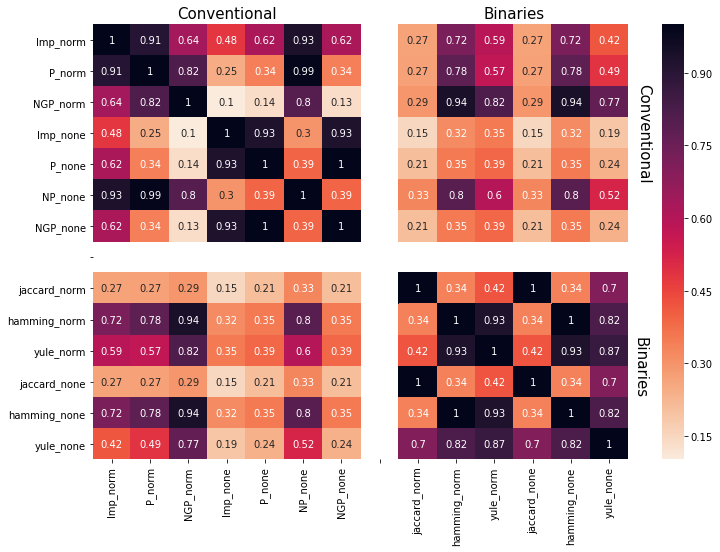

In [61]:
f, ax = plt.subplots(figsize=(12, 8))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: Treatment/Binary metric_data type')
print('Norm - MetaboScape normalized data')
print('None - MetaboScape not normalized data')
hm = sns.heatmap(df_SI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3.5,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(14.2,3.5,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(11,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(14.1,11,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: Treatment/Binary metric_data type
Norm - MetaboScape normalized data
None - MetaboScape not normalized data


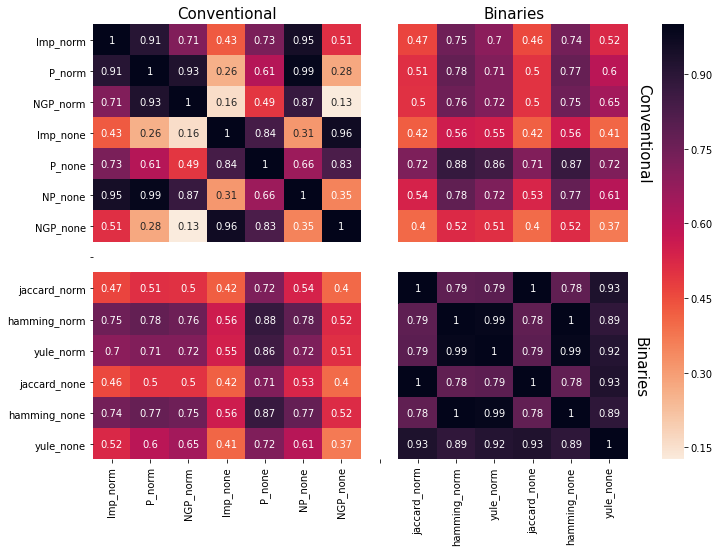

In [62]:
f, ax = plt.subplots(figsize=(12, 8))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: Treatment/Binary metric_data type')
print('Norm - MetaboScape normalized data')
print('None - MetaboScape not normalized data')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3.5,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(14.2,3.5,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(11,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(14.1,11,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other

Colours for these labels (groups: Norm Conventional, None Conventional, Norm Binary, None Binary)

In [63]:
label_colors2 = {}
colours2 = cm.get_cmap('nipy_spectral', 4)
col_lbl2 = colours2(range(4))
for i in range(2):
    label_colors2[df_K.columns[3*i]] = col_lbl2[i]
    label_colors2[df_K.columns[3*i+1]] = col_lbl2[i]
    label_colors2[df_K.columns[3*i+2]] = col_lbl2[i]
    label_colors2[df_K.columns[3*i+3]] = col_lbl2[i]
for i in range(3):
    label_colors2[df_K.columns[7+i]] = col_lbl2[2]
    label_colors2[df_K.columns[10+i]] = col_lbl2[3]

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: Treatment/Binary metric_data type
Norm - MetaboScape normalized data
None - MetaboScape not normalized data


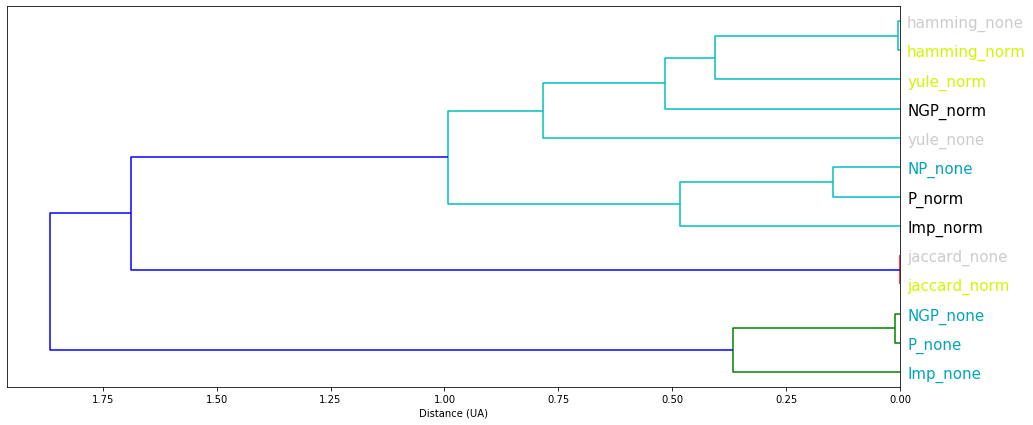

In [64]:
print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: Treatment/Binary metric_data type')
print('Norm - MetaboScape normalized data')
print('None - MetaboScape not normalized data')
Z_K = hier.linkage(df_K, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=df_K.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: Treatment/Binary metric_data type
Norm - MetaboScape normalized data
None - MetaboScape not normalized data


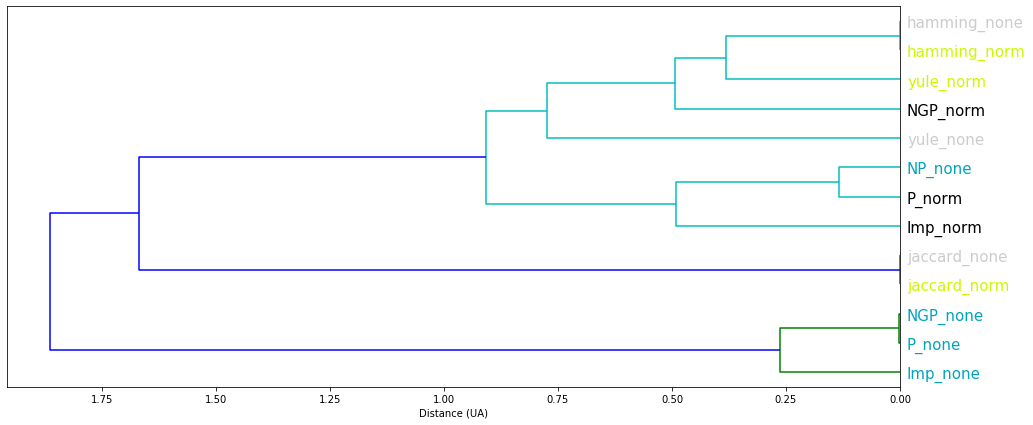

In [65]:
print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: Treatment/Binary metric_data type')
print('Norm - MetaboScape normalized data')
print('None - MetaboScape not normalized data')
Z_S = hier.linkage(df_S, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_S, labels=df_S.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: Treatment/Binary metric_data type
Norm - MetaboScape normalized data
None - MetaboScape not normalized data


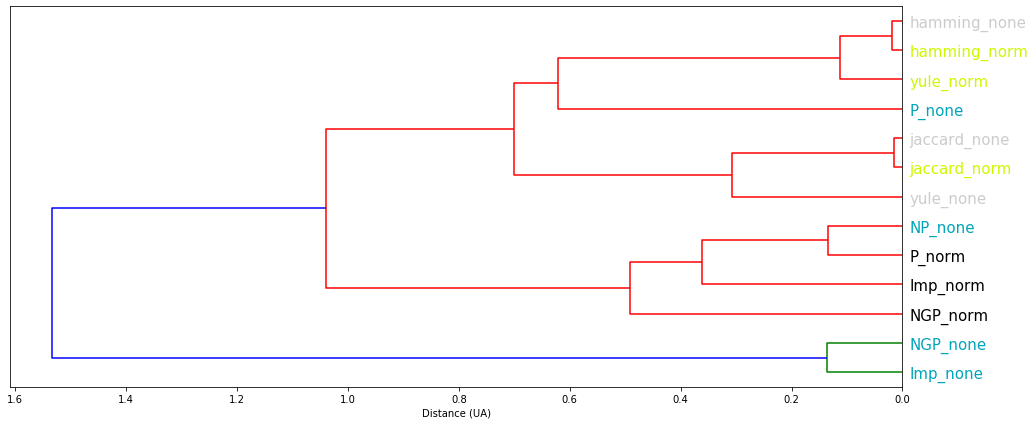

In [66]:
print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: Treatment/Binary metric_data type')
print('Norm - MetaboScape normalized data')
print('None - MetaboScape not normalized data')
Z_C = hier.linkage(df_C, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=df_C.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

### Distance discrimination of all methods applied (and shown in previous heatmap/dendrogram).

In [67]:
#Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_norm)
Z.extend(Z_none)

In [68]:
disc_average = np.zeros((1,13))
disc_median = np.zeros((1,13))
disc_correct = np.zeros((1,13))
for i in range(len(Z)):
    discrim = sca.dist_discrim(yeast_norm_nan, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = sca.dist_discrim(yeast_norm_nan, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:7], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,7:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:7], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,7:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:7], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,7:]], axis = 1)

Text(10.6, -0.2, 'Binaries')

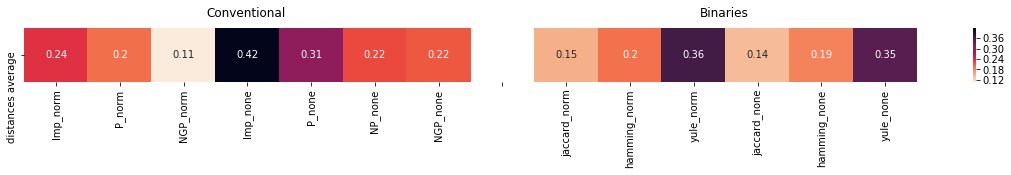

In [69]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(2.85,-0.2,'Conventional', fontsize  = 12)
plt.text(10.6,-0.2,'Binaries', fontsize = 12)

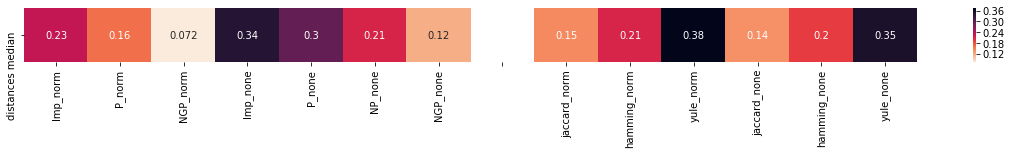

In [70]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

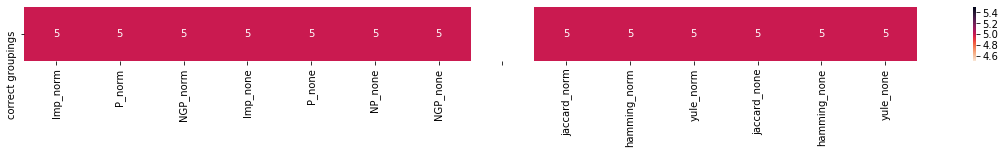

In [71]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

disc_average = np.zeros((1,13))
disc_median = np.zeros((1,13))
disc_correct = np.zeros((1,13))
for i in range(len(Z)):
    discrim = sca.dist_discrim(yeast_norm_nan, Z[i], 3, method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = sca.dist_discrim(yeast_norm_nan, Z[i], 3, 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,3:7], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,10:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,3:7], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,10:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,3:7], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,10:]], axis = 1)

f, ax = plt.subplots(figsize=(8, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(2,-0.2,'Conventional', fontsize  = 12, horizontalalignment='center')
plt.text(6.5,-0.2,'Binaries', fontsize  = 12, horizontalalignment='center')

f, ax = plt.subplots(figsize=(8, 1))
hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

f, ax = plt.subplots(figsize=(8, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means clustering

In [72]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [73]:
Kmean = skclust.KMeans(n_clusters=5)

In [74]:
a = Kmean.fit(NGP_none.data.T)

In [75]:
dicto = {}
for i in range(len(a.labels_)):
    if a.labels_[i] in dicto:
        dicto[a.labels_[i]].append(yeast_norm_nan.labels[i])
    else:
        dicto[a.labels_[i]] = [yeast_norm_nan.labels[i]]
dicto

{0: ['BY', 'BY', 'BY'],
 4: ['GRE3', 'GRE3', 'GRE3'],
 2: ['ENO1', 'ENO1', 'ENO1'],
 3: ['dGLO1', 'dGLO1', 'dGLO1'],
 1: ['GLO2', 'GLO2', 'GLO2']}

### K-means clustering applied to all euclidean methods and the binary matrixes built

To try and get a condensed and more easily digestible version of the results, a method similar to the discrimination distance performed in the hierarchical clustering was made. The same metrics as before are used.

Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero. Therefore, this method is harsher than the original dist_discrim method. The distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. This distance is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean/median of the discrimination distances of all groups is then a measure of the global discrimination distance

Use of the Kmeans_discrim function from multianalysis to calculate discrimination distance.

In [76]:
colnames2 = ['Imp_norm', 'P_norm', 'NGP_norm', 'Imp_none', 'P_none', 'NP_none','NGP_none', 'binary_norm','binary_none']

In [77]:
euclidean = (Imp_norm, P_norm, NGP_norm, Imp_none, P_none, NP_none, NGP_none)
binaries = (aligned_norm, aligned_none )

In [78]:
disc_average = np.zeros((1,9))
disc_median = np.zeros((1,9))
disc_correct = np.zeros((1,9))
for i in range(len(euclidean)):
    discrim = ma.Kmeans_discrim(euclidean[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.Kmeans_discrim(euclidean[i], method = 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
for i in range(len(binaries)):
    discrim = ma.Kmeans_discrim(AlignedSpectra(binaries[i], labels = yeast_norm_nan.labels), method = 'average')
    disc_average[0,7 + i] 
    disc_average[0,7 + i] = discrim[0]
    disc_median[0,7 + i] = ma.Kmeans_discrim(AlignedSpectra(binaries[i], labels = yeast_norm_nan.labels), method = 'median')[0] 
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,7 + i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames2)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames2)

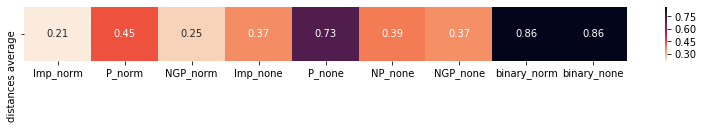

In [79]:
f, ax = plt.subplots(figsize=(13.5, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)

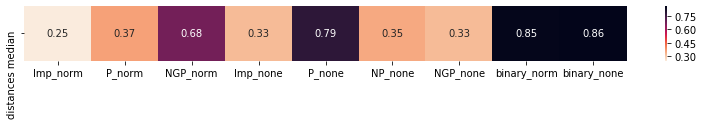

In [80]:
f, ax = plt.subplots(figsize=(13.5, 1))
hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

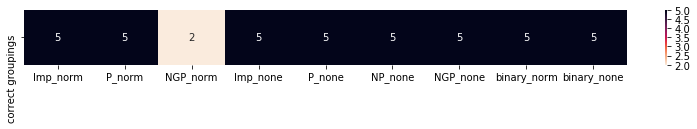

In [81]:
f, ax = plt.subplots(figsize=(13.5, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### RandomForests Attempts - 3-fold cross-validation, n_estimators = 200

This section of the notebook takes some time.

In [82]:
#Creation of "binary" Spectras using the binary matrices built with the function df_to_bool.
binary_norm = AlignedSpectra(aligned_norm, labels = yeast_norm_nan.labels)
binary_none = AlignedSpectra(aligned_none, labels = yeast_none_nan.labels)

In [83]:
euclidean = (Imp_norm, P_norm, NGP_norm, binary_norm, Imp_none, P_none, NP_none, NGP_none)
binaries = (aligned_norm, aligned_none)
colnames2 = ['Imp_norm', 'P_norm', 'NGP_norm', 'binary_norm','Imp_none', 'P_none', 'NP_none','NGP_none','binary_none']

### Test number of trees needed for convergence for N, NP, NGP and binary data (both alignments)

Grid search of number of trees from 10 to 1000 for the random forests. See where the cross-validation score stops improving for each one.

#### Takes  considerable time

In [84]:
#Vector with values for the parameter n_estimators
values = {}
values['n_estimators'] = range(10,150,10)

In [85]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv =3)

In [86]:
param = []
test_score = []
for i in range(len(euclidean)):
    clf.fit(euclidean[i].data.T, euclidean[i].labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
for i in range(len(binaries)):
    clf.fit(binaries[i].T, yeast_norm_nan.labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])

Performance based on number of trees - Alignment: None, Positive Mode


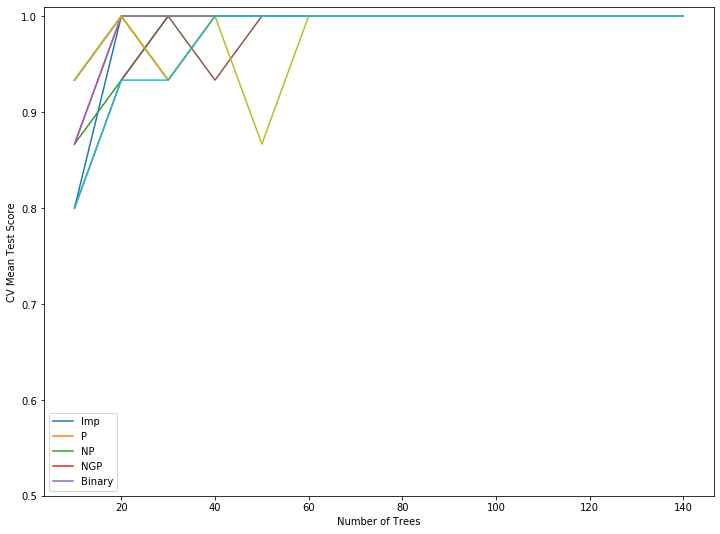

In [87]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(len(param)):
    plt.plot(param[i], test_score[i])
plt.ylabel('CV Mean Test Score')
plt.xlabel('Number of Trees')
plt.ylim([0.5,1.01])
ax.legend(['Imp','P', 'NP','NGP','Binary'])
print('Performance based on number of trees - Alignment: None, Positive Mode')

#### Applications of different methods

In [88]:
#Preparations of dicts:
Scores = {}
Scores_std = {}
Imp_feat = {}

### Attempt/Method nº1 - Direct

### Simple application of random forests

Since the dataset is small, the random forest classification is iterated 20 times to make sure more combinations of training and test samples are used. Then, an average of the results are obtained - number of random forests can be decided by iter_num. This is the same for all methods. 

To offset the small dataset, 3-fold Cross-Validation is used as an internal validation system evaluating the performance of the model based on its score/accuracy (3-fold since that is maximum number possible since every group of samples only has 3 replicates.

Besides the 3-fold cross-validation score, the order of the average of most important features across the random forests (with each iteration and group in cross-validation having the same weight) is extracted from the forests "built".

Now to run the random forests on the different datasets (negative and positive of both alignments) both in their "normal" and "binary" matrices form. For the normal or euclidean matrices, only the data concerning the P data processing was used since it was the best performer of all former methods employed.

Application of the function simple_RF from multianalysis.

In [89]:
#euclidean = (Imp_norm, P_norm, NGP_norm, Imp_none, P_none, NP_none, NGP_none, binary_norm, binary_none)
I1_D = ma.simple_RF(Imp_norm, iter_num = 100)#(Scores, Cohen's Kappa Score, order of features based on importances, 3-fold cross-validation)
Scores['Imp_norm'] = np.mean(I1_D[0])
Scores_std['Imp_norm'] = np.std(I1_D[0])
Imp_feat['Imp_norm'] = I1_D[1]

In [90]:
P1_D = ma.simple_RF(P_norm, iter_num = 100)
Scores['P_norm'] = np.mean(P1_D[0])
Scores_std['P_norm'] = np.std(P1_D[0])
Imp_feat['P_norm'] = P1_D[1]

In [91]:
NGP1_D = ma.simple_RF(NGP_norm, iter_num = 100)
Scores['NGP_norm'] = np.mean(NGP1_D[0])
Scores_std['NGP_norm'] = np.std(NGP1_D[0])
Imp_feat['NGP_norm'] = NGP1_D[1]

In [92]:
I2_D = ma.simple_RF(Imp_none, iter_num = 100)
Scores['Imp_none'] = np.mean(I2_D[0])
Scores_std['Imp_none'] = np.std(I2_D[0])
Imp_feat['Imp_none'] = I2_D[1]

In [93]:
P2_D = ma.simple_RF(P_none, iter_num = 100)
Scores['P_none'] = np.mean(P2_D[0])
Scores_std['P_none'] = np.std(P2_D[0])
Imp_feat['P_none'] = P2_D[1]

In [94]:
NP2_D = ma.simple_RF(NP_none, iter_num = 100)
Scores['NP_none'] = np.mean(NP2_D[0])
Scores_std['NP_none'] = np.std(NP2_D[0])
Imp_feat['NP_none'] = NP2_D[1]

In [95]:
NGP2_D = ma.simple_RF(NGP_none, iter_num = 100)
Scores['NGP_none'] = np.mean(NGP2_D[0])
Scores_std['NGP_none'] = np.std(NGP2_D[0])
Imp_feat['NGP_none'] = NGP2_D[1]

In [96]:
B1_D = ma.simple_RF(binary_norm, iter_num = 100)
Scores['binary_norm'] = np.mean(B1_D[0])
Scores_std['binary_norm'] = np.std(B1_D[0])
Imp_feat['binary_norm'] = B1_D[1]

In [97]:
B2_D = ma.simple_RF(binary_none, iter_num = 100)
Scores['binary_none'] = np.mean(B2_D[0])
Scores_std['binary_none'] = np.std(B2_D[0])
Imp_feat['binary_none'] = B2_D[1]

### Attempt/Method nº2 - SMOTE -  NOT APPLIED SO FAR - Code in Markdown

### Oversampling data with SMOTE before splitting cross-validation groups. Expected better results due to bleed.

All the same specifications as method nº1 but with an oversampling of the data that doubles the amount of samples (from 39 to 78) which means each cross-valdiation group will have 2 replicates for each variety instead of one.

As mentioned in the title, this means there will be a "bleeding" of the data between test and training groups due to the samples in the test group having been originated from the ones in the training group or have been used to originate data in training groups. Therefore, the score of this method should be higher than the other due to an overestimation of how good the model is due to this bleeding.

SMOTE oversampling is performed in the initial imputated data by the function fast_SMOTE from multianalysis.py. 

Therefore we have to run the NGP data processing again for each dataset.

#Neg1
Imp_S_neg = ma.fast_SMOTE(Imputated_neg)
Norm_S_neg = sca.Norm_Feat(Imp_S_neg, 554.26202)
glog_S_neg = sca.glog(Norm_S_neg, 0)
Euc_NGP_S_neg = sca.ParetoScal(glog_S_neg)
#Neg2
Imp_S_neg2 = ma.fast_SMOTE(Imputated_neg2)
Norm_S_neg2 = sca.Norm_Feat(Imp_S_neg2, 554.26202)
glog_S_neg2 = sca.glog(Norm_S_neg2, 0)
Euc_NGP_S_neg2 = sca.ParetoScal(glog_S_neg2)
#Pos1
Imp_S_pos = ma.fast_SMOTE(Imputated_pos)
Norm_S_pos = sca.Norm_Feat(Imp_S_pos, 556.2765712820513)
glog_S_pos = sca.glog(Norm_S_pos, 0)
Euc_NGP_S_pos = sca.ParetoScal(glog_S_pos)
#Pos2
Imp_S_pos2 = ma.fast_SMOTE(Imputated_pos2)
Norm_S_pos2 = sca.Norm_Feat(Imp_S_pos2, 556.2765712820513)
glog_S_pos2 = sca.glog(Norm_S_pos2, 0)
Euc_NGP_S_pos2 = sca.ParetoScal(glog_S_pos2)
#Binaries
binary_S_neg1 = ma.fast_SMOTE(binary_neg1, binary = True)
binary_S_neg2 = ma.fast_SMOTE(binary_neg2, binary = True)
binary_S_pos1 = ma.fast_SMOTE(binary_pos1, binary = True)
binary_S_pos2 = ma.fast_SMOTE(binary_pos2, binary = True)

N1_B = ma.simple_RF(Euc_NGP_S_neg)
Scores['neg2-1_bleed'] = N1_B[0]
CKS['neg2-1_bleed'] = N1_B[1]
Imp_feat['neg2-1_bleed'] = N1_B[2]
Cross_Val['neg2-1_bleed'] = N1_B[3]

P1_B = ma.simple_RF(Euc_NGP_S_pos)
Scores['pos2-1_bleed'] = P1_B[0]
CKS['pos2-1_bleed'] = P1_B[1]
Imp_feat['pos2-1_bleed'] = P1_B[2]
Cross_Val['pos2-1_bleed'] = P1_B[3]

N2_B = ma.simple_RF(Euc_NGP_S_neg2)
Scores['neg3-3_bleed'] = N2_B[0]
CKS['neg3-3_bleed'] = N2_B[1]
Imp_feat['neg3-3_bleed'] = N2_B[2]
Cross_Val['neg3-3_bleed'] = N2_B[3]

P2_B = ma.simple_RF(Euc_NGP_S_pos2)
Scores['pos3-3_bleed'] = P2_B[0]
CKS['pos3-3_bleed'] = P2_B[1]
Imp_feat['pos3-3_bleed'] = P2_B[2]
Cross_Val['pos3-3_bleed'] = P2_B[3]

BN1_B = ma.simple_RF(binary_S_neg1)
Scores['neg2-1_bin_bleed'] = BN1_B[0]
CKS['neg2-1_bin_bleed'] = BN1_B[1]
Imp_feat['neg2-1_bin_bleed'] = BN1_B[2]
Cross_Val['neg2-1_bin_bleed'] = BN1_B[3]

BP1_B = ma.simple_RF(binary_S_pos1)
Scores['pos2-1_bin_bleed'] = BP1_B[0]
CKS['pos2-1_bin_bleed'] = BP1_B[1]
Imp_feat['pos2-1_bin_bleed'] = BP1_B[2]
Cross_Val['pos2-1_bin_bleed'] = BP1_B[3]

BN2_B = ma.simple_RF(binary_S_neg2)
Scores['neg3-3_bin_bleed'] = BN2_B[0]
CKS['neg3-3_bin_bleed'] = BN2_B[1]
Imp_feat['neg3-3_bin_bleed'] = BN2_B[2]
Cross_Val['neg3-3_bin_bleed'] = BN2_B[3]

BP2_B = ma.simple_RF(binary_S_pos2)
Scores['pos3-3_bin_bleed'] = BP2_B[0]
CKS['pos3-3_bin_bleed'] = BP2_B[1]
Imp_feat['pos3-3_bin_bleed'] = BP2_B[2]
Cross_Val['pos3-3_bin_bleed'] = BP2_B[3]

### Results of the Random Forests surmised in Heatmaps


In [98]:
Scores_H = pd.DataFrame(list(Scores.values()), index = Scores.keys()).T
Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

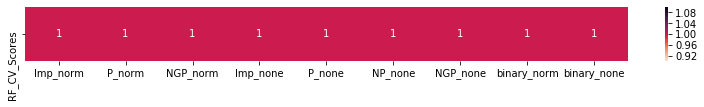

In [99]:
f, ax = plt.subplots(figsize=(13.5, 1))
hm = sns.heatmap(Scores_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_Scores'])

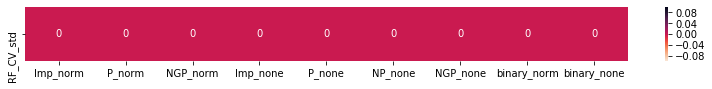

In [100]:
f, ax = plt.subplots(figsize=(13.5, 1))
hm = sns.heatmap(Scores_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

### Characteristics of the features seen as important in the different alignments, data treatments and modes (negative and positive)

We take the 2% most important features in each case and calculate the average number of samples those features appear (samples_m), the average number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 3). We also see how many times the importance of the most importante feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('more').

A scatter plot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

In [101]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature and calculating
#% explained by these features (more)
ev = []
magni = []
more = []
for j in Imp_feat:#['neg2-1_direct']:
    if j.endswith('norm'):
        Spectra = yeast_norm_nan
    elif j.endswith('none'):
        Spectra = yeast_none_nan
    ratio = []
    nsamples = []
    n_groups = []
    number = round(0.02*len(Spectra))
    magni.append(Imp_feat[j][0][1]/(1/len(Spectra)))
    a = 0
    for i in range(number): 
        a = a + Imp_feat[j][i][1]*100 
        ngroups = {}
        line = Spectra.data.loc[Imp_feat[j][i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    more.append(a)
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)
#print(ev[4])

In [102]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = [i  for i in Imp_feat])
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([line, df.iloc[0:3],line, df.iloc[3:7],line, df.iloc[7:]])

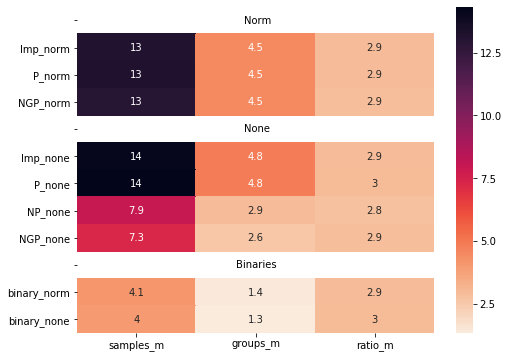

In [103]:
f, ax = plt.subplots(figsize=(8, 6))
mask = df.isnull()
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r, mask = mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.4,0.6,'Norm')
plt.text(1.4,4.6,'None')
plt.text(1.34,9.6,'Binaries')
plt.show()

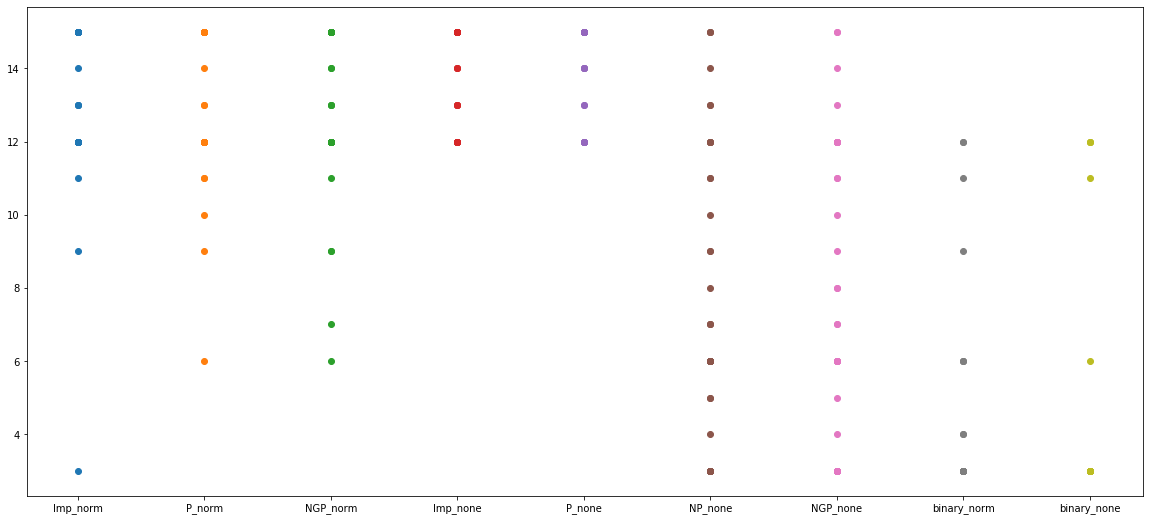

In [104]:
f, ax = plt.subplots(figsize=(20, 9))
for i in range(len(ev)):
    plt.scatter([list(Imp_feat.keys())[i]]*len(ev[i]), ev[i].iloc[:,0])
plt.show()

In [105]:
print('Magnitude of most important feature:', magni)
print('% of model explained by the 2% most important features', more)

Magnitude of most important feature: [4.036592629069001, 4.255837392321872, 4.0625423330577535, 3.8686002818426397, 4.199047152573665, 2.4568885328483865, 2.556946549184066, 4.8260929326082245, 5.237760351323432]
% of model explained by the 2% most important features [6.5718634677496786, 6.566753061139209, 6.565924352587544, 6.754412862421806, 6.6970083160818605, 4.1294902111401175, 4.065001973837198, 8.003005739222335, 7.969537849024551]


### Extracting a single decision tree

In [106]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(NGP_none.data.T, NGP_none.labels, test_size=0.1)
rf = skensemble.RandomForestClassifier(n_estimators = 200)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Decision Tree


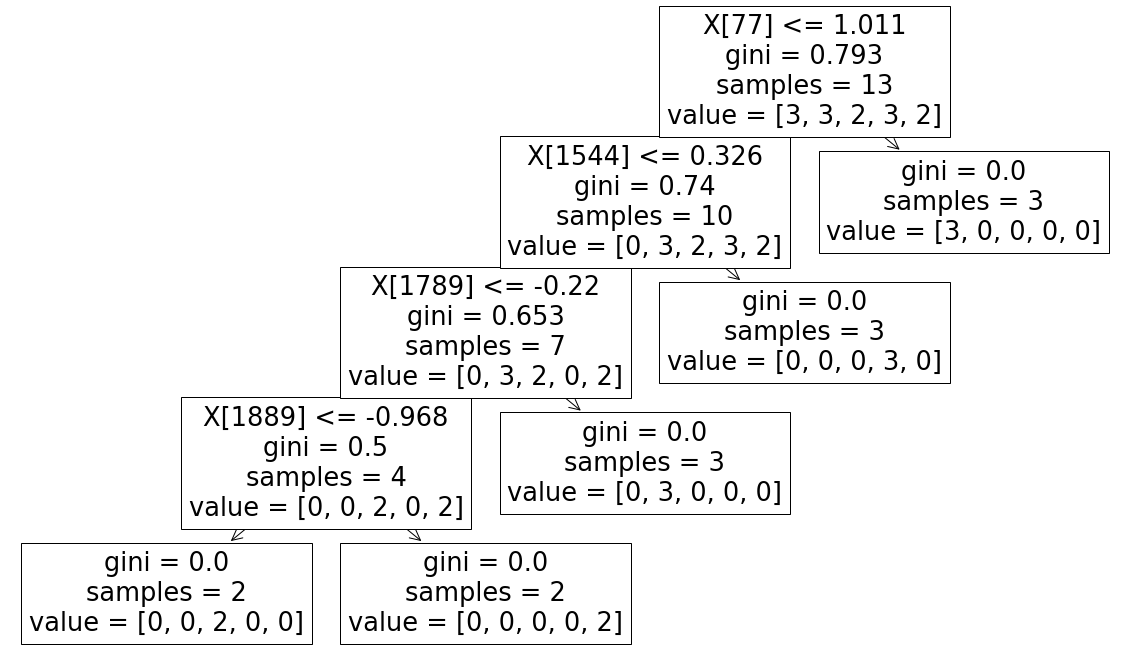

In [107]:
from sklearn import tree
fig = plt.figure(figsize=(20,12))
clf = rf.estimators_[2].fit(X_train, y_train)
tree.plot_tree(clf)
print('Decision Tree')

### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

In [108]:
matrix = pd.get_dummies(yeast_norm_nan.labels)
matrix = matrix[["BY","GRE3","ENO1","dGLO1","GLO2"]]

### Search for the best number of components to use

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with 3-fold cross-validation (3 was chosen since it is the max for our dataset - 3 replicates in each group, having an added bonus of still maintaining a balanced dataset). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 30 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function optim_PLS in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [109]:
%%capture
#PLS applied in the MetScape Normalized Dataset.
Imp_norm_PLS = ma.optim_PLS(Imp_norm, matrix, max_comp = 30)
P_norm_PLS = ma.optim_PLS(P_norm, matrix, max_comp = 30)
NGP_norm_PLS = ma.optim_PLS(NGP_norm, matrix, max_comp = 30)
bin_norm_PLS = ma.optim_PLS(binary_norm, matrix, max_comp = 30)

#PLS applied in the non-MetScape Normalized Dataset.
Imp_none_PLS = ma.optim_PLS(Imp_none, matrix, max_comp = 30)
P_none_PLS = ma.optim_PLS(P_none, matrix, max_comp = 30)
NP_none_PLS = ma.optim_PLS(NP_none, matrix, max_comp = 30)
NGP_none_PLS = ma.optim_PLS(NGP_none, matrix, max_comp = 30)
bin_none_PLS = ma.optim_PLS(binary_none, matrix, max_comp = 30)

Performance based on number of components - Normalized Mode


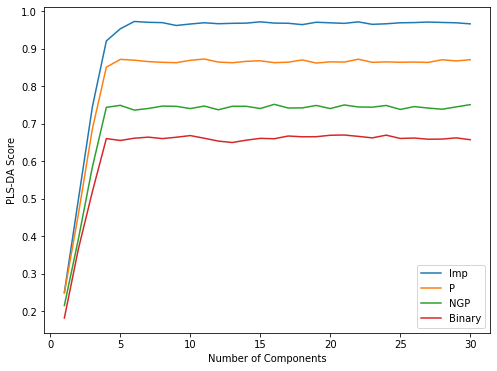

In [110]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,31),Imp_norm_PLS[0])
plt.plot(range(1,31),P_norm_PLS[0])
plt.plot(range(1,31),NGP_norm_PLS[0])
plt.plot(range(1,31),bin_norm_PLS[0])
plt.ylabel('PLS-DA Score')
plt.xlabel('Number of Components')
ax.legend(('Imp', 'P', 'NGP', 'Binary'))
print('Performance based on number of components - Normalized Mode')

Performance based on number of components - Normalized Mode


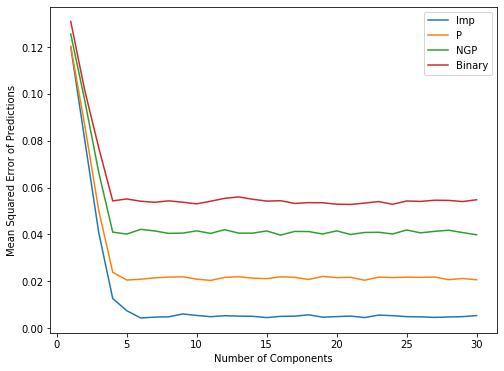

In [111]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,31),Imp_norm_PLS[2])
plt.plot(range(1,31),P_norm_PLS[2])
plt.plot(range(1,31),NGP_norm_PLS[2])
plt.plot(range(1,31),bin_norm_PLS[2])
plt.ylabel('Mean Squared Error of Predictions')
plt.xlabel('Number of Components')
ax.legend(('Imp', 'P', 'NGP', 'Binary'))
print('Performance based on number of components - Normalized Mode')

Performance based on number of components - Not-Normalized Mode


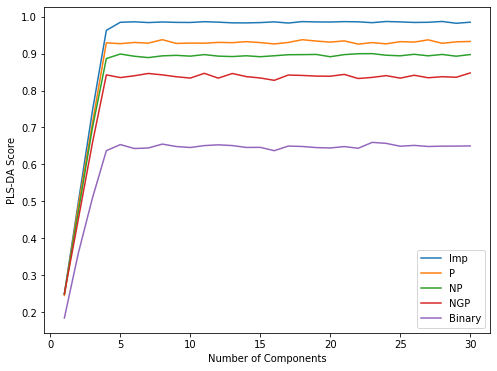

In [112]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,31),Imp_none_PLS[0])
plt.plot(range(1,31),P_none_PLS[0])
plt.plot(range(1,31),NP_none_PLS[0])
plt.plot(range(1,31),NGP_none_PLS[0])
plt.plot(range(1,31),bin_none_PLS[0])
plt.ylabel('PLS-DA Score')
plt.xlabel('Number of Components')
ax.legend(('Imp','P', 'NP', 'NGP', 'Binary'))
print('Performance based on number of components - Not-Normalized Mode')

Performance based on number of components - Not-Normalized Mode


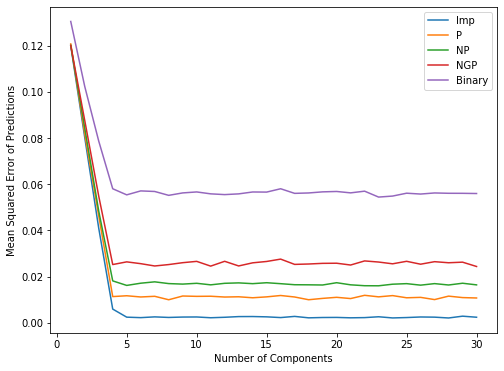

In [113]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,31),Imp_none_PLS[2])
plt.plot(range(1,31),P_none_PLS[2])
plt.plot(range(1,31),NP_none_PLS[2])
plt.plot(range(1,31),NGP_none_PLS[2])
plt.plot(range(1,31),bin_none_PLS[2])
plt.ylabel('Mean Squared Error of Predictions')
plt.xlabel('Number of Components')
ax.legend(('Imp','P', 'NP', 'NGP', 'Binary'))
print('Performance based on number of components - Not-Normalized Mode')

### Application of PLS-DA

The number of components seemed to be converged when it reached around 4/5 so 6 components were used from now on. Also MSE is the inverse of the score given by the PLS function of the module scikit-learn so from now on we will only collect the score knowing its meaning.

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in 3 different groups as 3-fold cross-validation.

In [114]:
PLS_accu = {}
PLS_score = {}
PLS_weights = {}
PLS_RegCoef = {}

In [115]:
%%capture
Imp_norm_PLS = ma.model_PLSDA(Imp_norm, matrix, n_comp = 6, iter_num = 100)
PLS_accu['Imp_norm'] = Imp_norm_PLS[0]
PLS_score['Imp_norm'] = Imp_norm_PLS[1]
PLS_weights['Imp_norm'] = Imp_norm_PLS[3]
PLS_RegCoef['Imp_norm'] = Imp_norm_PLS[4]

P_norm_PLS = ma.model_PLSDA(P_norm, matrix, n_comp = 6, iter_num = 100)
PLS_accu['P_norm'] = P_norm_PLS[0]
PLS_score['P_norm'] = P_norm_PLS[1]
PLS_weights['P_norm'] = P_norm_PLS[3]
PLS_RegCoef['P_norm'] = P_norm_PLS[4]

NGP_norm_PLS = ma.model_PLSDA(NGP_norm, matrix, n_comp = 6, iter_num = 100)
PLS_accu['NGP_norm'] = NGP_norm_PLS[0]
PLS_score['NGP_norm'] = NGP_norm_PLS[1]
PLS_weights['NGP_norm'] = NGP_norm_PLS[3]
PLS_RegCoef['NGP_norm'] = NGP_norm_PLS[4]

bin_norm_PLS = ma.model_PLSDA(binary_norm, matrix, n_comp = 6, iter_num = 100)
PLS_accu['bin_norm'] = bin_norm_PLS[0]
PLS_score['bin_norm'] = bin_norm_PLS[1]
PLS_weights['bin_norm'] = bin_norm_PLS[3]
PLS_RegCoef['bin_norm'] = bin_norm_PLS[4]

In [116]:
%%capture
Imp_none_PLS = ma.model_PLSDA(Imp_none, matrix, n_comp = 6, iter_num = 100)
PLS_accu['Imp_none'] = Imp_none_PLS[0]
PLS_score['Imp_none'] = Imp_none_PLS[1]
PLS_weights['Imp_none'] = Imp_none_PLS[3]
PLS_RegCoef['Imp_none'] = Imp_none_PLS[4]

P_none_PLS = ma.model_PLSDA(P_none, matrix, n_comp = 6, iter_num = 100)
PLS_accu['P_none'] = P_none_PLS[0]
PLS_score['P_none'] = P_none_PLS[1]
PLS_weights['P_none'] = P_none_PLS[3]
PLS_RegCoef['P_none'] = P_none_PLS[4]

NP_none_PLS = ma.model_PLSDA(NP_none, matrix, n_comp = 6, iter_num = 100)
PLS_accu['NP_none'] = NP_none_PLS[0]
PLS_score['NP_none'] = NP_none_PLS[1]
PLS_weights['NP_none'] = NP_none_PLS[3]
PLS_RegCoef['NP_none'] = NP_none_PLS[4]

NGP_none_PLS = ma.model_PLSDA(NGP_none, matrix, n_comp = 6, iter_num = 100)
PLS_accu['NGP_none'] = NGP_none_PLS[0]
PLS_score['NGP_none'] = NGP_none_PLS[1]
PLS_weights['NGP_none'] = NGP_none_PLS[3]
PLS_RegCoef['NGP_none'] = NGP_none_PLS[4]

bin_none_PLS = ma.model_PLSDA(binary_none, matrix, n_comp = 6, iter_num = 100)
PLS_accu['bin_none'] = bin_none_PLS[0]
PLS_score['bin_none'] = bin_none_PLS[1]
PLS_weights['bin_none'] = bin_none_PLS[3]
PLS_RegCoef['bin_none'] = bin_none_PLS[4]

Accuracy based on the dataset


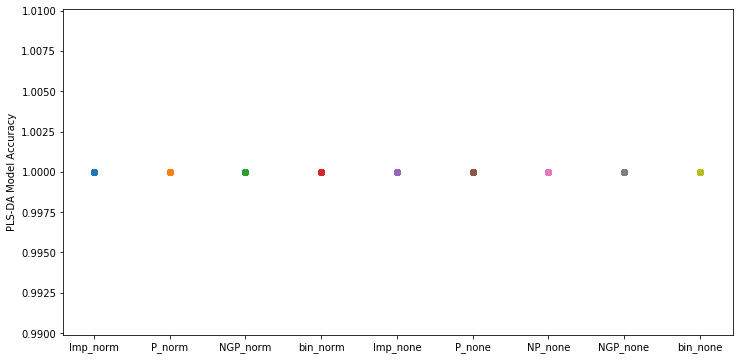

In [117]:
f, ax = plt.subplots(figsize=(12,6))
plt.scatter(['Imp_norm']*len(PLS_accu['Imp_norm']), PLS_accu['Imp_norm'])
plt.scatter(['P_norm']*len(PLS_accu['P_norm']), PLS_accu['P_norm'])
plt.scatter(['NGP_norm']*len(PLS_accu['NGP_norm']), PLS_accu['NGP_norm'])
plt.scatter(['bin_norm']*len(PLS_accu['bin_norm']), PLS_accu['bin_norm'])
plt.scatter(['Imp_none']*len(PLS_accu['Imp_none']), PLS_accu['Imp_none'])
plt.scatter(['P_none']*len(PLS_accu['P_none']), PLS_accu['P_none'])
plt.scatter(['NP_none']*len(PLS_accu['NP_none']), PLS_accu['NP_none'])
plt.scatter(['NGP_none']*len(PLS_accu['NGP_none']), PLS_accu['NGP_none'])
plt.scatter(['bin_none']*len(PLS_accu['bin_none']), PLS_accu['bin_none'])
plt.ylabel('PLS-DA Model Accuracy')
print('Accuracy based on the dataset')

Performance score based on the dataset


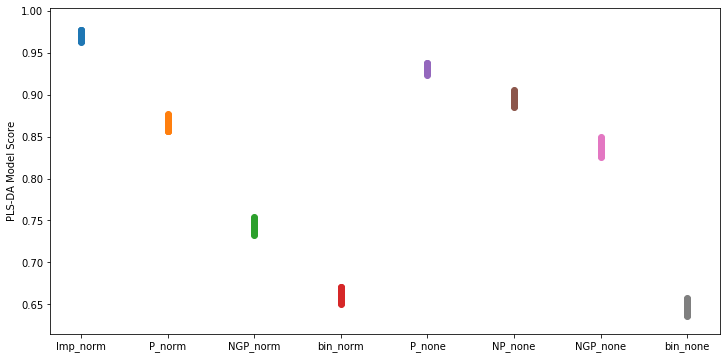

In [118]:
f, ax = plt.subplots(figsize=(12,6))
plt.scatter(['Imp_norm']*len(PLS_score['Imp_norm']), PLS_score['Imp_norm'])
plt.scatter(['P_norm']*len(PLS_score['P_norm']), PLS_score['P_norm'])
plt.scatter(['NGP_norm']*len(PLS_score['NGP_norm']), PLS_score['NGP_norm'])
plt.scatter(['bin_norm']*len(PLS_score['bin_norm']), PLS_score['bin_norm'])
plt.scatter(['P_none']*len(PLS_score['P_none']), PLS_score['P_none'])
plt.scatter(['NP_none']*len(PLS_score['NP_none']), PLS_score['NP_none'])
plt.scatter(['NGP_none']*len(PLS_score['NGP_none']), PLS_score['NGP_none'])
plt.scatter(['bin_none']*len(PLS_score['bin_none']), PLS_score['bin_none'])
plt.ylabel('PLS-DA Model Score')
print('Performance score based on the dataset')

In [119]:
Accuracy = {}
Accuracy['Imp_norm'] = np.mean(PLS_accu['Imp_norm'])
Accuracy['P_norm'] = np.mean(PLS_accu['P_norm'])
Accuracy['NGP_norm'] = np.mean(PLS_accu['NGP_norm'])
Accuracy['bin_norm'] = np.mean(PLS_accu['bin_norm'])
Accuracy['Imp_none'] = np.mean(PLS_accu['Imp_none'])
Accuracy['P_none'] = np.mean(PLS_accu['P_none'])
Accuracy['NP_none'] = np.mean(PLS_accu['NP_none'])
Accuracy['NGP_none'] = np.mean(PLS_accu['NGP_none'])
Accuracy['bin_none'] = np.mean(PLS_accu['bin_none'])

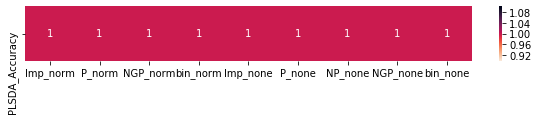

In [120]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

In [121]:
Score = {}
Score['Imp_norm'] = np.mean(PLS_score['Imp_norm'])
Score['P_norm'] = np.mean(PLS_score['P_norm'])
Score['NGP_norm'] = np.mean(PLS_score['NGP_norm'])
Score['bin_norm'] = np.mean(PLS_score['bin_norm'])
Score['Imp_none'] = np.mean(PLS_score['Imp_none'])
Score['P_none'] = np.mean(PLS_score['P_none'])
Score['NP_none'] = np.mean(PLS_score['NP_none'])
Score['NGP_none'] = np.mean(PLS_score['NGP_none'])
Score['bin_none'] = np.mean(PLS_score['bin_none'])

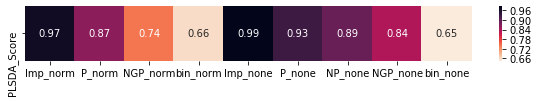

In [122]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [123]:
Accuracy_std = {}
Accuracy_std['Imp_norm'] = np.std(PLS_accu['Imp_norm'])
Accuracy_std['P_norm'] = np.std(PLS_accu['P_norm'])
Accuracy_std['NGP_norm'] = np.std(PLS_accu['NGP_norm'])
Accuracy_std['bin_norm'] = np.std(PLS_accu['bin_norm'])
Accuracy_std['Imp_none'] = np.std(PLS_accu['Imp_none'])
Accuracy_std['P_none'] = np.std(PLS_accu['P_none'])
Accuracy_std['NP_none'] = np.std(PLS_accu['NP_none'])
Accuracy_std['NGP_none'] = np.std(PLS_accu['NGP_none'])
Accuracy_std['bin_none'] = np.std(PLS_accu['bin_none'])

In [124]:
Score_std = {}
Score_std['Imp_norm'] = np.std(PLS_score['Imp_norm'])
Score_std['P_norm'] = np.std(PLS_score['P_norm'])
Score_std['NGP_norm'] = np.std(PLS_score['NGP_norm'])
Score_std['bin_norm'] = np.std(PLS_score['bin_norm'])
Score_std['Imp_none'] = np.std(PLS_score['Imp_none'])
Score_std['P_none'] = np.std(PLS_score['P_none'])
Score_std['NP_none'] = np.std(PLS_score['NP_none'])
Score_std['NGP_none'] = np.std(PLS_score['NGP_none'])
Score_std['bin_none'] = np.std(PLS_score['bin_none'])

In [125]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())
Accuracy_H.T

,Accuracy,SD
Imp_norm,1.0,0.0
P_norm,1.0,0.0
NGP_norm,1.0,0.0
bin_norm,1.0,0.0
Imp_none,1.0,0.0
P_none,1.0,0.0
NP_none,1.0,0.0
NGP_none,1.0,0.0
bin_none,1.0,0.0


In [126]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys(), columns  = ['Score']).T
Score_H.loc['SD'] = list(Score_std.values())
Score_H.T

,Score,SD
Imp_norm,0.969728,0.002966
P_norm,0.866779,0.004380
NGP_norm,0.743951,0.003883
bin_norm,0.660684,0.004509
Imp_none,0.985007,0.001556
P_none,0.929985,0.002637
NP_none,0.894676,0.003964
NGP_none,0.838864,0.004562
bin_none,0.646475,0.004309


### Characteristics of the most important features

The characteristics of the most important features for each of the methods is done by the same process as applied in the random forests section of the notebook.

In [127]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
Imp_feat = (PLS_weights, PLS_RegCoef)
ev = []
magni = []
index = []
for m in Imp_feat:
    for j in m:
        if j.endswith('norm'):
            Spectra = yeast_norm_nan
        elif j.endswith('none'):
            Spectra = yeast_none_nan
        index.append(j)
        ratio = []
        nsamples = []
        n_groups = []
        number = round(0.02*len(Spectra))
        total_m = 0
        for i in range(len(m[j])):
            total_m = total_m + m[j][i][1]
        magni.append(m[j][0][1]/(total_m/len(Spectra)))
        for i in range(number): 
            ngroups = {}
            line = Spectra.data.loc[m[j][i][2],:].notnull()
            nsamples.append(line.sum())
            for n in range(len(line)):
                if line[n] == True:
                    ngroups[Spectra.labels[n]] = 1
            n_groups.append(sum(list((ngroups.values()))))
            ratio.append(nsamples[-1]/n_groups[-1])
        df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
        df['nsamples'] = nsamples
        df['n_groups'] = n_groups
        df['ratio']  = ratio
        ev.append(df)

In [128]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = index)
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:9], line, df.iloc[9:]])

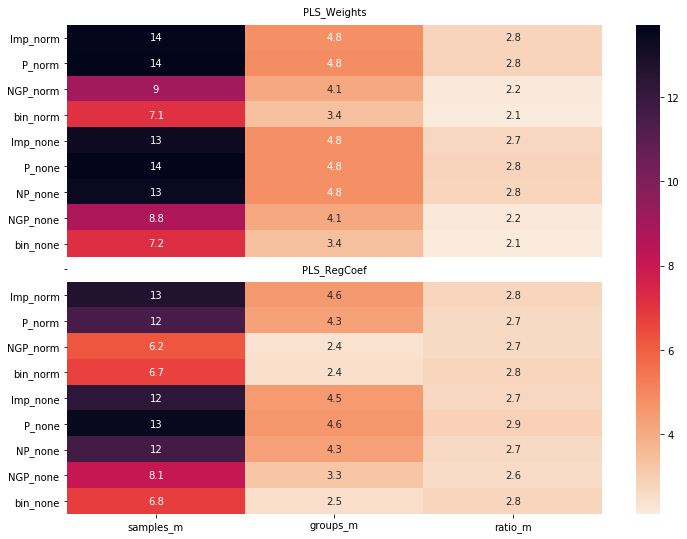

In [129]:
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'PLS_Weights',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,9.5,'PLS_RegCoef',horizontalalignment='center', verticalalignment='center')
plt.show()

In [130]:
print('Magnitude of most important features for each case:')
print(magni)

Magnitude of most important features for each case:
[33.74289493051303, 8.410655860181516, 1.931130444261026, 1.9080814285186858, 38.035564376685954, 12.942932814052583, 8.37003685508654, 2.4022602369241666, 1.919735037013719, 23.48994909306174, 8.965974087061612, 2.756536327519362, 2.678901099581563, 37.81075761192632, 15.667763258300976, 10.240025422222113, 3.484810252812296, 2.6835300517490523]


### Model with the full dataset and sample representation on the two most important Components/Latent Variables

NGP data treatment for the non previously normalized dataset (None)

In [131]:
from sklearn.cross_decomposition import PLSRegression

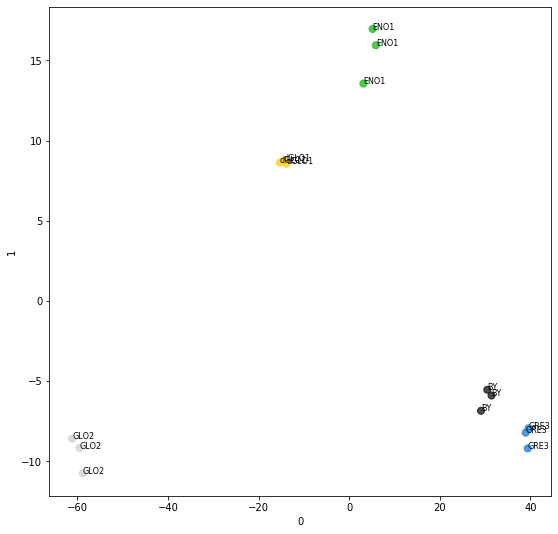

In [132]:
plsda = PLSRegression(n_components = 6)
#Fitting the model and getting the X_scores
plsda.fit(X=NGP_none.data.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 5)
col_lbl = colours(range(5))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

    #Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = Spectra.unique_labels()[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

Binary processed data for the non previously normalized dataset (None)

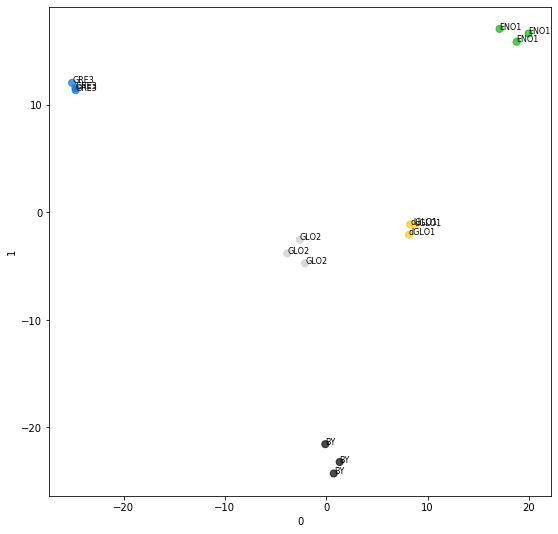

In [133]:
plsda = PLSRegression(n_components = 6)
#Fitting the model and getting the X_scores
plsda.fit(X=binary_none.data.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 5)
col_lbl = colours(range(5))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

#Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, c = col_lbl, figsize=(9,9))
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%3 == 0:
        i = i + 1
        label = Spectra.unique_labels()[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

In [134]:
def Feat_Selection_sim(VIP_s, Weight_s, RegCoef_s, percent = 0.02):
    """See the similarity of features chosen (% of intersection between them) with different methods."""
    number = round(percent*len(VIP_s))
    VIP = []
    Weights = []
    RegCoef = []
    for i in range(number):
        VIP.append(VIP_s[:number][i][0])
        Weights.append(Weight_s[:number][i][0])
        RegCoef.append(RegCoef_s[:number][i][0])
    Features = (VIP, Weights, RegCoef)
    Table = pd.DataFrame(np.empty((3,3)), columns = ['VIP', 'Weights', 'RegCoef'], index = ['VIP', 'Weights', 'RegCoef'])
    for i in range(len(Features)):
        for j in range(len(Features)):
            #list comprehension other way
            Table.iloc[i,j] = len(set(Features[i]).intersection(Features[j]))/number
    return Table